In [1]:
"""
Purpose: To gather the orientation preferences and the soma center data and try to find different ways to correlate

Pseudocode:
1) Find the data for the oma locations
2) Find way to extract the orientation preferences and bin them
3) Get the total distributions the orientation| preferences from inside the volume
4) Start with a given neuron: 
a. Do radius testing:
    - plot the overall distribution of circular orinetation difference from that neuron for the whole volume
    - gather all of the neurons that are within a certain radius
    - plot the distirbutions of circular orinetation difference from that neuron for neurons within that radius
    - continue and vary the size of the radius
b. Columns of X, Y, Z (same as radius testing)
    - need to vary the widths and sizes of the columns like varying the size of the radius

"""

'\nPurpose: To gather the orientation preferences and the soma center data and try to find different ways to correlate\n\nPseudocode:\n1) Find the data for the oma locations\n2) Find way to extract the orientation preferences and bin them\n3) Get the total distributions the orientation| preferences from inside the volume\n4) Start with a given neuron: \na. Do radius testing:\n    - plot the overall distribution of circular orinetation difference from that neuron for the whole volume\n    - gather all of the neurons that are within a certain radius\n    - plot the distirbutions of circular orinetation difference from that neuron for neurons within that radius\n    - continue and vary the size of the radius\nb. Columns of X, Y, Z (same as radius testing)\n    - need to vary the widths and sizes of the columns like varying the size of the radius\n\n'

In [2]:
import numpy as np
import datajoint as dj

# ********************load the data from local file******************

In [3]:
import numpy as np
import datajoint as dj

orientation_center_data = np.load("orientation_center_data.npz",allow_pickle=True)
orientation_center_data.files
soma_cell_data = orientation_center_data["soma_cell_data"] #stores the soma id, segment_id and the x,y,z coordinates as well as the cell_class = excitatory
orientation_preference = orientation_center_data["orientation_preference"] #the orientation preferences in radians that correspond tot he 
seg_ids = orientation_center_data["seg_ids"] #the segment ids for the orientation preferences

#build a lookup dictionary for segment ids to orientation
seg_id_to_orientation = dict([(seg_ids[k],orientation_preference[k]) for k in range(0,len(seg_ids))])
#seg_id_to_orientation

# Where to start in offline version:

In [4]:

attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.25'

rf_bin_edges = np.linspace(-.7, .7, 6) #setting the bin boundaries


"""
Calculate the bins and centers for the orientational preference
"""
#defines how to find the "tuned" segments of the orientation
dori_resolution = np.pi / 2 / 4 #setting the width size of the bins to be 22.5 degrees
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9) #creates 8 bins between boundaries between 0 and pi


#sets the threshold for the 
stat_choice = ["synapse_vol_density_pearson"]

ori_confidence=0.5
von_p_value=0.05

rf_bin_edges=rf_bin_edges
ori_bin_edges=bin_edges
n_seg_shared_threshold = 10
n_seg_shared_converted_threshold = 10
rf_threshold=1.45

###Orientation
rad2deg = 180/np.pi
# turns all of the bin edges into degrees with no decimal
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_bin_edges]])
#creates the bin boundary markings with [low - high]
bin_labels = list(zip(be[:-1], be[1:]))

#calculates the bin centers
bin_centers = np.round((ori_bin_edges[1:] + ori_bin_edges[:-1])/2 * rad2deg, decimals=2)

In [6]:
"""
The cdiff computes the angle 
that the second angle has to move in order to meet
up with the first angle

Where if you have to move counterclockwise --> positive
If you have to move clockwise --> negative

"""

import pycircstat as pycs

def center_angle(angle):
    return (angle + np.pi) % (2*np.pi) - np.pi

def cdiff(alpha, beta):
    """
    Difference between pairs :math:`x_i-y_i` around the circle,
    computed efficiently.
    :param alpha:  sample of circular random variable
    :param beta:   sample of circular random variable
    :return: distance between the pairs
    """
    return center_angle(alpha - beta)
def cdiff_orientation(alpha,beta):
    return center_angle(alpha*2 - beta*2)/2

# Visualizing the Data (for the whole volume): 

In [7]:
# set up bins for difference in prefered orientation
n_bins = 20
lower_bin_bound = 0
upper_bin_bound = np.pi
rad2deg = 180/np.pi
ori_edges = np.linspace(lower_bin_bound, upper_bin_bound, n_bins+1)
oe = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_edges]])
ori_labels = list(zip(oe[:-1], oe[1:]))
ori_centers = np.round((ori_edges[1:] + ori_edges[:-1])/2 * rad2deg, decimals=2) 
print("ori_centers = " + str(ori_centers))

bin_centers = ori_centers
ori_bin_edges=ori_edges
binned_ori_preferences = bin_centers[(np.digitize(orientation_preference, ori_bin_edges))-1]
raw_orientation_degrees = (np.array(orientation_preference)*rad2deg).astype("int")

#np.vstack([binned_ori_preferences.T,raw_orientation_degrees.T]).T
#cdf['bdori'] = bin_centers[(np.digitize(np.abs(cdf["dori"]), ori_bin_edges))-1]

ori_centers = [  4.5  13.5  22.5  31.5  40.5  49.5  58.5  67.5  76.5  85.5  94.5 103.5
 112.5 121.5 130.5 139.5 148.5 157.5 166.5 175.5]


In [8]:
"""
For the whole volume: Gets all the bins of the orientation and how many neurons in each group
"""

from collections import Counter
my_counter = Counter(binned_ori_preferences)
#print(my_counter)
binned_angles = np.array(list(my_counter.keys()))
binned_angles_histogram = np.array(list(my_counter.values()))
print(binned_angles,binned_angles_histogram)

[ 58.5  67.5 130.5 157.5  13.5 175.5   4.5  40.5 139.5  85.5  94.5 148.5
 166.5  49.5 112.5 103.5  22.5  76.5 121.5  31.5] [ 8 12 18 35  9 23 20  8 28 11 16 21 19 12 11  7 11 11  9 10]


<BarContainer object of 20 artists>

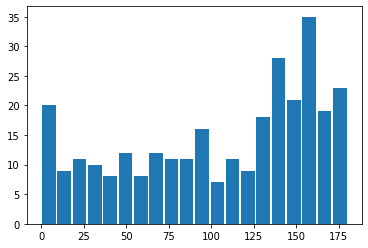

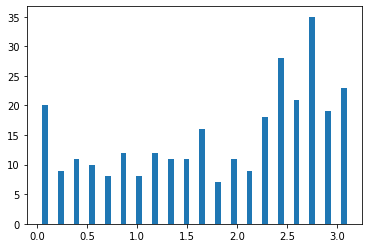

In [9]:
#plot as distribution of the orientations in the whole volume
import matplotlib.pyplot as plt

plt.figure()
plt.bar(binned_angles,binned_angles_histogram,width=rad2deg*(ori_edges[1]-ori_edges[0])-1)
#plot as radians
plt.figure()
plt.bar(binned_angles/rad2deg,binned_angles_histogram,width=ori_edges[1]-ori_edges[0]-0.1)

# -- Step 2: Get distribution stats of the circular data --

In [11]:
"""practices getting the circular statistics for orientation that only ranges from 0 - 180"""

binned_ori_preferences 
doubled_orientation_preference = np.array(orientation_preference)*2
np.max(doubled_orientation_preference),np.min(doubled_orientation_preference)

"""mean
pairwise_cdiff
cdiff: Difference between pairs
(angle + np.pi) % (2*np.pi) - np.pi
median
"""
print("mean = " + str(pycs.mean(doubled_orientation_preference)/2))
print("variance = " + str(pycs.var(doubled_orientation_preference)/4))
print("std deviation = " + str(pycs.std(doubled_orientation_preference)/2))


mean = 2.7184592481507632
variance = 0.18750687786523423
std deviation = 0.8325876569524456


# Finding vector between soma ceneters and finding true distance:

In [12]:
"""Turns the downloaded table of soma data into a dictionary with the segment_id as the key"""
soma_cell_data
soma_cell_location_dict = dict([(k["segment_id"],dict(location=np.array([k["soma_x"],k["soma_y"],k["soma_z"]]),x_loc=k["soma_x"],y_loc=k["soma_y"],z_loc=k["soma_z"])) for k in soma_cell_data])
#soma_cell_location_dict

In [13]:
""" Demonstrates how to get the distance between the two somas"""
seg_1 = 648518346341371119
seg_2 = 648518346349470171
location_1 = soma_cell_location_dict[seg_1]["location"]
location_2 = soma_cell_location_dict[seg_2]["location"]
print(location_1,location_2)
print(np.linalg.norm(location_1-location_2))

"""
Proving that distane works: 
np.sqrt((location_1[0] - location_2[0])**2 +
       (location_1[1] - location_2[1])**2 + 
        (location_1[2] - location_2[2])**2)
"""

[105998  71204    669] [108628  45213   1136]
26127.898308130334


'\nProving that distane works: \nnp.sqrt((location_1[0] - location_2[0])**2 +\n       (location_1[1] - location_2[1])**2 + \n        (location_1[2] - location_2[2])**2)\n'

In [14]:
"""create a 2D array that has the distances between each cell pair
Includes the:
1) overall distance 
2) Distance along each axis
"""
from tqdm import tqdm

soma_distance_array = dict()

for seg_1 in tqdm(soma_cell_location_dict.keys()):
    for seg_2 in soma_cell_location_dict.keys():
        location_1 = soma_cell_location_dict[seg_1]["location"]
        location_2 = soma_cell_location_dict[seg_2]["location"]
        if seg_1 not in soma_distance_array.keys():
            soma_distance_array[seg_1] = dict()
        soma_distance_array[seg_1][seg_2] = dict(distance=np.linalg.norm(location_1-location_2),
                                                 x_distance = location_1[0] - location_2[0], 
                                                 y_distance = location_1[1] - location_2[1], 
                                                 z_distance = location_1[2] - location_2[2])
        

100%|██████████| 75/75 [00:00<00:00, 747.43it/s]


In [15]:
print(soma_cell_location_dict[648518346341371119])
location_1=soma_cell_location_dict[648518346341371119]["location"]
print(soma_cell_location_dict[648518346349470171])
location_2=soma_cell_location_dict[648518346349470171]["location"]
location_1[0] - location_2[0]
location_1[1] - location_2[1]

{'location': array([105998,  71204,    669]), 'x_loc': 105998, 'y_loc': 71204, 'z_loc': 669}
{'location': array([108628,  45213,   1136]), 'x_loc': 108628, 'y_loc': 45213, 'z_loc': 1136}


25991

In [16]:
# Functions that will find the subgroup:

def find_column_subgroup(width_axis ,
                         height_axis,
                        target_neuron,
                        total_neurons_list,
                        box_width=13000,
                         box_height=13000,):
    """
    Returns the list of ids for neurons in a column
    Speicifed by the parameters
    """
    column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis]) < box_width)
                                                                      and (abs(soma_distance_array[target_neuron][k][height_axis]) < box_height))]
    return column_neurons

def find_radius_subgroup(target_neuron,
                        total_neurons_list,
                        circular_radius=15000):
    """
    Returns the list of ids for neurons in a column
    Speicifed by the parameters
    """
    
    circular_radius_neurons = [k for k in total_neurons_list if np.abs(soma_distance_array[target_neuron][k]["distance"]) < circular_radius ]
    return circular_radius_neurons


def print_3D_visuals(soma_centers_list,c_values,target_neuron,target_val):
    #helps gets the ranges to use for limits
    total_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])
    mins = np.min(total_list,axis=0) 
    maxs = np.max(total_list,axis=0)
    min_max_ranges = maxs - mins
    buffer_percentage = 0.1
    mins = np.min(total_list,axis=0) - buffer_percentage*min_max_ranges
    maxs = np.max(total_list,axis=0) + buffer_percentage*min_max_ranges
    
    #get the location of the target neuron
    loc = soma_cell_location_dict[target_neuron]["location"]
    target_x = loc[0]
    target_y = loc[1]
    target_z = loc[2]
    target_scatter_size = 20*4**2
    
    fig = plt.figure(figsize=(16,4))
    fig.tight_layout()
    ax = plt.subplot(1,3,1)
    sc = ax.scatter(soma_centers_list[:,0],
               soma_centers_list[:,1], 
               c=c_values, 
               marker='o')
    ax.scatter(target_x,target_y,marker='X',s=target_scatter_size)
    ax.set_xlim([mins[0],maxs[0]])
    ax.set_ylim([mins[1],maxs[1]])
    ax.set_xlabel('x axis')
    ax.set_ylabel('Y axis')


    ax = plt.subplot(1,3,2)

    sc = ax.scatter(soma_centers_list[:,0],
               soma_centers_list[:,2], 
               c=c_values, 
               marker='o')

    ax.scatter(target_x,target_z,marker='X',s=target_scatter_size)
    ax.set_xlabel('x axis')
    ax.set_ylabel('z axis')
    ax.set_xlim([mins[0],maxs[0]])
    ax.set_ylim([mins[2],maxs[2]])


    ax = plt.subplot(1,3,3)
    sc = ax.scatter(soma_centers_list[:,1],
               soma_centers_list[:,2], 
               c=c_values, 
               marker='o')
    ax.scatter(target_y,target_z,marker='X',s=target_scatter_size)
    ax.set_xlabel('y axis')
    ax.set_ylabel('z axis')
    plt.colorbar(sc)
    ax.set_xlim([mins[1],maxs[1]])
    ax.set_ylim([mins[2],maxs[2]])


    #soma_cell_location_dict
    from matplotlib import pyplot
    from mpl_toolkits.mplot3d import Axes3D
    import random


    fig = pyplot.figure()
    ax = Axes3D(fig)

    sc = ax.scatter(soma_centers_list[:,0], soma_centers_list[:,1], soma_centers_list[:,2],c=c_values)
    ax.scatter(target_x,target_y,marker='X',s=target_scatter_size)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_xlim([mins[0],maxs[0]])
    ax.set_ylim([mins[1],maxs[1]])
    ax.set_zlim([mins[2],maxs[2]])
    plt.colorbar(sc)
    pyplot.show()

# Visualizing the Subgroups 

7
22


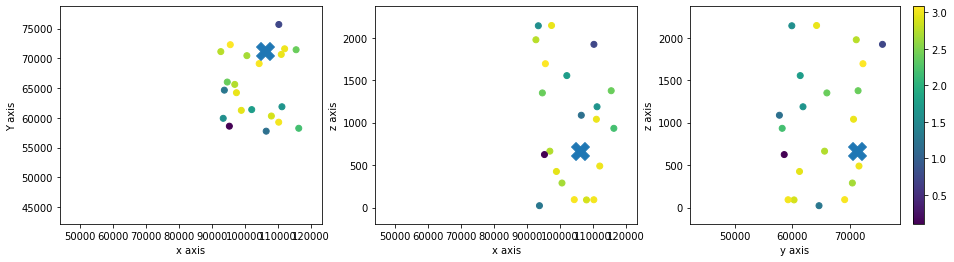

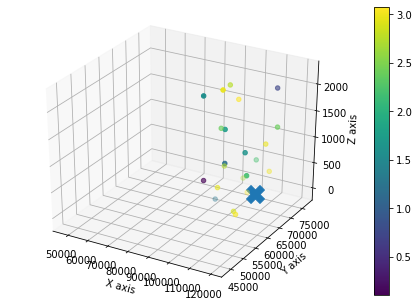

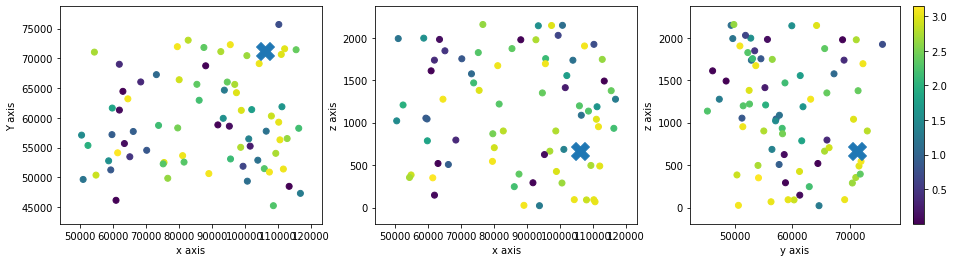

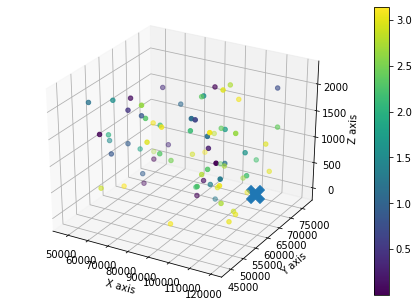

In [18]:
target_neuron = 648518346341371119
total_neurons_list = soma_cell_location_dict.keys()
circular_radius = 10000

circular_group = find_radius_subgroup(target_neuron,
                        total_neurons_list,
                        circular_radius)


box_width = 14000
box_height = 14000
width_axis = "x_distance"
height_axis = "y_distance"
z_column_group =  find_column_subgroup(width_axis ,
                         height_axis,
                        target_neuron,
                        total_neurons_list,
                        box_width,
                         box_height)

print(len(circular_group))
print(len(z_column_group))

new_group = z_column_group
ori_pref = [seg_id_to_orientation[a] for a in new_group]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])
np.min(soma_centers_list,axis=0),np.max(soma_centers_list,axis=0)

new_group
ori_pref = [seg_id_to_orientation[a] for a in new_group]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in new_group])
target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
c_values = [seg_id_to_orientation[k] for k in new_group]

print_3D_visuals(soma_centers_list,c_values,target_neuron,target_neuron_orientation_preferene)

#graph all in comparison
new_group = soma_cell_location_dict.keys()
ori_pref = [seg_id_to_orientation[a] for a in new_group]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in new_group])
target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
c_values = [seg_id_to_orientation[k] for k in new_group]

print_3D_visuals(soma_centers_list,c_values,target_neuron,target_neuron_orientation_preferene)

# current_subgroup = column_neurons
# ori_pref = [seg_id_to_orientation[a] for a in current_subgroup]
# soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in current_subgroup])

# print_3D_visuals(soma_centers_list,ori_pref)

In [21]:
def bin_orientation_data(orientation_preference,
                         n_bins = 20,
                        lower_bin_bound = 0,
                         upper_bin_bound = np.pi):
    """
    Functions that will do binning of data
    Bases on the number of bins, lower bound and upper bound specified
    """
    
    rad2deg = 180/np.pi
    ori_edges = np.linspace(lower_bin_bound, upper_bin_bound, n_bins+1)
    oe = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_edges]])
    ori_labels = list(zip(oe[:-1], oe[1:]))
    ori_centers = np.round((ori_edges[1:] + ori_edges[:-1])/2 * rad2deg, decimals=2) 

    bin_centers = ori_centers
    ori_bin_edges=ori_edges
    binned_ori_preferences = bin_centers[(np.digitize(orientation_preference, ori_bin_edges))-1]
    raw_orientation_degrees = (np.array(orientation_preference)*rad2deg).astype("int")
    
    from collections import Counter
    my_counter = Counter(binned_ori_preferences)
    #print(my_counter)
    binned_angles = np.array(list(my_counter.keys()))
    binned_angles_histogram = np.array(list(my_counter.values()))
    
    return binned_angles,binned_angles_histogram

def plot_circular_distribution_lite(theta,
                               radii,
                                    ax,
                                    n_bins,
                               width=-1,
                               bottom = 8):
    
    """
    will plot the circulation distribution given the 
    1) theta (x values)
    2) radii (y values)
    
    Other parameters passed: 
    0) axis to plot it on
    1) number of bins that could possibly be plotted
    
    optional
    1) Width of each of the bins (else it is calculated)
    2) bottom: The offset where the histogram starts
    
    
    
    
    """
    N = n_bins
    
    if width == -1:
        width = (2*np.pi) / N

    #ax = plt.subplot(111, polar=True)
    bars = ax.bar(theta, radii, width=width, bottom=bottom)

    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.jet(r / 10.))
        bar.set_alpha(0.8)
    #ax.set_yticks([0,45,90,135,180])
    """
    ax.set_xticks(np.pi/180. * np.linspace(0,  180, 8, endpoint=False))
    ax.set_thetalim(0,np.pi)
    """
    ax.set_xticklabels(np.linspace(0,  180, 8, endpoint=False))
    #plt.show()

def graph_binned_orientation_data(binned_angles,
                                binned_angles_histogram,
                                  neuron_id,
                                  title,
                                  n_bins,
                                  global_binned_angles = [],
                                global_binned_angles_histogram= [],
                                 graphs_to_plot=[],
                                  figure_size = (20,20),
                                 circular_flag = True,
                                 target_neuron_orientation = -1,
                                 target_color="y"):
    """
    Will graph the linear/circular or both of the distribution of a certain group
    1) Will graph just the local group or global group alone if only
    "local" or "global" sent in graph to plot
    
    And then highlight the target neuron's orientation 
    """
    
    axis_label_size=20
    tick_label_size = 20
    title_size=30
    
    # if circular plots were also requested then adjust overall size
    if circular_flag:
        n_subplot = 2*len(graphs_to_plot)
    else:
        n_subplot = len(graphs_to_plot)
    
    width_size = 5
    #print("n_subplot = " + str(n_subplot))
    currnet_subplot = 1
    fig = plt.figure(figsize=(figure_size[0],figure_size[1]*len(graphs_to_plot)))
    fig.tight_layout()
    #fig.set_size_inches(20, 12)
    if "local" in graphs_to_plot:
        
        if circular_flag:
            ax = plt.subplot(n_subplot,2,currnet_subplot)
            #graphing the linear graph
            plt.bar(binned_angles,binned_angles_histogram,width=width_size)
            if target_neuron_orientation != -1:
                plt.bar(target_neuron_orientation,[0.5],width=width_size,color=target_color)
#                 print(" target_neuron_orientation[0] = " + str( target_neuron_orientation[0]))
#                 print("binned_angles = " + str(binned_angles))
#                 angle_index = np.where(binned_angles == target_neuron_orientation[0])[0]
#                 if len(angle_index) == 0:
#                     target_neuron_height = 0.5
#                 else:
#                     target_neuron_height = binned_angles_histogram[angle_index]
#                 print("angle_index = " + str(angle_index))
#                 print("target_neuron_orientation/rad2deg = " + str(target_neuron_orientation/rad2deg))
#                 print("[target_neuron_height] =  " + str([target_neuron_height]))
#                 plt.bar(target_neuron_orientation/rad2deg,[target_neuron_height],width=width_size,color=target_color)
                #             ax.set(
#                    title=title + "_linear",
#                    ylabel='Number of Neurons',
#                    xlabel='Radians',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_linear",fontsize=title_size)
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
            
            #graphing the circular graph
            ax = plt.subplot(n_subplot,2,currnet_subplot+1,polar=True)
            plot_circular_distribution_lite(binned_angles/rad2deg*2,
                                            binned_angles_histogram,
                                            ax,
                                           n_bins)
            
#             ax.set(
#                    title=title + "_circular",
#                    ylabel='Number of Neurons',
#                    xlabel='Degrees',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_circular",fontsize=title_size)
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
#             ax.set_xticklabels(ax.get_xticklabels(),fontsize=tick_label_size)
#             ax.set_yticklabels(ax.get_yticklabels(),fontsize=tick_label_size)
            
            #increment the current_subplot
            currnet_subplot += 2
        else:
            ax = plt.subplot(n_subplot,1,currnet_subplot)
            #graphing the linear graph
            plt.bar(binned_angles,binned_angles_histogram,width=width_size)
            if target_neuron_orientation != -1:
                plt.bar(target_neuron_orientation,[0.5],width=width_size,color=target_color)
#             ax.set(
#                    title=title + "_linear",
#                    ylabel='Number of Neurons',
#                    xlabel='Radians',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_linear",fontsize=title_size)
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
            #increment the current_subplot
            currnet_subplot += 1
    
    print("\n\n\n")
    if "global" in graphs_to_plot:
        binned_angles = global_binned_angles
        binned_angles_histogram =  global_binned_angles_histogram
        if circular_flag:
            ax = plt.subplot(n_subplot,2,currnet_subplot)
            #graphing the linear graph
            plt.bar(binned_angles,binned_angles_histogram,width=width_size)
            
#             ax.set(
#                    title=title + "_linear",
#                    ylabel='Number of Neurons',
#                    xlabel='Radians',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_global_linear",fontsize=title_size)
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
            
            #graphing the circular graph
            ax = plt.subplot(n_subplot,2,currnet_subplot+1,polar=True)
            plot_circular_distribution_lite(binned_angles/rad2deg*2,
                                            binned_angles_histogram,
                                            ax,n_bins)
            
#             ax.set(
#                    title=title + "_circular",
#                    ylabel='Number of Neurons',
#                    xlabel='Degrees',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_global_circular",fontsize=title_size)
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
#             ax.set_xticklabels(ax.get_xticklabels(),fontsize=tick_label_size)
#             ax.set_yticklabels(ax.get_yticklabels(),fontsize=tick_label_size)
            
            #increment the current_subplot
            currnet_subplot += 2
        else:
            ax = plt.subplot(n_subplot,1,currnet_subplot)
            #graphing the linear graph
            plt.bar(binned_angles,binned_angles_histogram,width=width_size)
            
#             ax.set(
#                    title=title + "_linear",
#                    ylabel='Number of Neurons',
#                    xlabel='Radians',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_global",fontsize=title_size)
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
            #increment the current_subplot
            currnet_subplot += 1
    left = 0.125
    right = 0.9
    bottom = 0.1
    top = 0.9
    wspace = 0.2
    hspace = 0.5
    fig.subplots_adjust(left=left,bottom=bottom,right=right,
                       top=top,wspace=wspace,hspace=hspace)

binned_angles,binned_angles_histogram = bin_orientation_data(orientation_preference,
                                                         n_bins = 20,
                                                        lower_bin_bound = 0,
                                                         upper_bin_bound = np.pi)

# graph_binned_orientation_data(binned_angles,
#                                 binned_angles_histogram,
#                                   neuron_id=45,
#                               n_bins=20,
#                                   title="example_type",
#                               global_binned_angles = binned_angles,
#                                 global_binned_angles_histogram= binned_angles_histogram,
#                                  graphs_to_plot=["local","global"],
#                                  figure_size = (20,20),
#                                  circular_flag = True)

# Find good column and radius 

In [23]:
circular_radius = 1000

box_width = 1000

suitable_number_threshold = 10
total_neurons_in_cluster = []

suitable_number = False
while suitable_number == False:
    for target_neuron in list(soma_cell_location_dict.keys()):
        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)

        circular_radius_neurons = [k for k in total_neurons_list if soma_distance_array[target_neuron][k]["distance"] < circular_radius ]
        #print("len(circular_radius_neurons) = " + str(len(circular_radius_neurons)))
        total_neurons_in_cluster.append(len(circular_radius_neurons))

        """
        Example of how to find neurons within x column
        """
    # evaluate if enough neurons in each cluster (if 90 percent have 10 or more)
    percentage_above_threshold = np.sum(np.array(total_neurons_in_cluster) >= suitable_number_threshold)/len(total_neurons_in_cluster)
    if percentage_above_threshold >= 0.9:
        suitable_number = True
    else:
        circular_radius += 100
        total_neurons_in_cluster = []
        
    
print("total_neurons_in_cluster = " + str(total_neurons_in_cluster))
print("Final circular_radius for circular  = " + str(circular_radius))

"""
Final size: suitable number would be 15000
"""


suitable_number_threshold = 10
box_width = 1000
width_axis = "x_distance"
height_axis = "y_distance"

total_neurons_in_cluster = []

suitable_number = False
while suitable_number == False:
    for target_neuron in list(soma_cell_location_dict.keys()):
        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)

        column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis]) < box_width)
                                                                      and (abs(soma_distance_array[target_neuron][k][height_axis]) < box_width))]
        #print("len(circular_radius_neurons) = " + str(len(circular_radius_neurons)))
        total_neurons_in_cluster.append(len(column_neurons))

        """
        Example of how to find neurons within x column
        """
    # evaluate if enough neurons in each cluster (if 90 percent have 10 or more)
    percentage_above_threshold = np.sum(np.array(total_neurons_in_cluster) >= suitable_number_threshold)/len(total_neurons_in_cluster)
    if percentage_above_threshold >= 0.9:
        suitable_number = True
    else:
        box_width += 50
        total_neurons_in_cluster = []

#print the suitable threshold
print("total_neurons_in_cluster Z AXIS = " + str(total_neurons_in_cluster))
print("Final box_width for circular  Z AXIS = " + str(box_width))

suitable_number_threshold = 10
box_width = 1000
width_axis = "y_distance"
height_axis = "z_distance"

total_neurons_in_cluster = []

suitable_number = False
while suitable_number == False:
    for target_neuron in list(soma_cell_location_dict.keys()):
        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)

        column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis]) < box_width)
                                                                      and (abs(soma_distance_array[target_neuron][k][height_axis]) < box_width))]
        #print("len(circular_radius_neurons) = " + str(len(circular_radius_neurons)))
        total_neurons_in_cluster.append(len(column_neurons))

        """
        Example of how to find neurons within x column
        """
    # evaluate if enough neurons in each cluster (if 90 percent have 10 or more)
    percentage_above_threshold = np.sum(np.array(total_neurons_in_cluster) >= suitable_number_threshold)/len(total_neurons_in_cluster)
    if percentage_above_threshold >= 0.9:
        suitable_number = True
    else:
        box_width += 50
        total_neurons_in_cluster = []

#print the suitable threshold
print("total_neurons_in_cluster X AXIS = " + str(total_neurons_in_cluster))
print("Final box_width for circular  X AXIS = " + str(box_width))

suitable_number_threshold = 10
box_width = 1000
width_axis = "x_distance"
height_axis = "z_distance"

total_neurons_in_cluster = []

suitable_number = False
while suitable_number == False:
    for target_neuron in list(soma_cell_location_dict.keys()):
        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)

        column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis]) < box_width)
                                                                      and (abs(soma_distance_array[target_neuron][k][height_axis]) < box_width))]
        #print("len(circular_radius_neurons) = " + str(len(circular_radius_neurons)))
        total_neurons_in_cluster.append(len(column_neurons))

        """
        Example of how to find neurons within x column
        """
    # evaluate if enough neurons in each cluster (if 90 percent have 10 or more)
    percentage_above_threshold = np.sum(np.array(total_neurons_in_cluster) >= suitable_number_threshold)/len(total_neurons_in_cluster)
    if percentage_above_threshold >= 0.9:
        suitable_number = True
    else:
        box_width += 50
        total_neurons_in_cluster = []

#print the suitable threshold
print("total_neurons_in_cluster Y AXIS = " + str(total_neurons_in_cluster))
print("Final box_width for circular  Y AXIS = " + str(box_width))



# column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis]) < box_width)
#                                                                       and (abs(soma_distance_array[target_neuron][k][height_axis]) < box_width))]

# # print("len(column_neurons) = " + str(len(column_neurons)))
# # print(column_neurons)


total_neurons_in_cluster = [17, 14, 16, 10, 25, 10, 19, 15, 25, 24, 19, 17, 23, 28, 19, 24, 15, 22, 16, 21, 8, 20, 10, 22, 13, 19, 12, 19, 18, 28, 21, 19, 17, 23, 30, 11, 21, 12, 14, 28, 22, 20, 12, 28, 24, 10, 30, 21, 16, 13, 21, 18, 20, 15, 17, 21, 6, 12, 10, 5, 24, 23, 21, 17, 15, 19, 9, 10, 9, 15, 16, 11, 20, 9, 9]
Final circular_radius for circular  = 13700
total_neurons_in_cluster Z AXIS = [14, 14, 14, 11, 24, 12, 17, 12, 23, 23, 20, 16, 23, 27, 18, 24, 14, 22, 16, 19, 9, 18, 9, 21, 13, 18, 12, 18, 18, 26, 20, 20, 17, 22, 29, 12, 21, 10, 11, 26, 21, 16, 12, 27, 23, 10, 31, 22, 17, 12, 21, 17, 15, 16, 17, 21, 6, 10, 10, 5, 22, 22, 21, 14, 14, 19, 9, 8, 7, 13, 14, 11, 22, 10, 10]
Final box_width for circular  Z AXIS = 11900
total_neurons_in_cluster X AXIS = [13, 2, 9, 20, 21, 20, 21, 15, 12, 16, 13, 20, 19, 20, 19, 21, 19, 18, 20, 11, 12, 19, 14, 20, 16, 17, 19, 21, 18, 18, 18, 12, 19, 10, 12, 3, 20, 21, 17, 20, 12, 10, 11, 15, 17, 12, 13, 10, 13, 10, 12, 12, 13, 12, 12, 20, 1, 13,

# Part 2: Start Testing 

In [24]:
"""
Final conclusion
going to use 13000 as the width size: which is about the area of 4 somas arranged in square
--- because the width is an absolute value ---

"""

'\nFinal conclusion\ngoing to use 13000 as the width size: which is about the area of 4 somas arranged in square\n--- because the width is an absolute value ---\n\n'

# 1) **************   Visual Test of whether finding Circular and Column Neurons work ***************

len(circular_radius_neurons) = 18
len(column_neurons) = 36
[648518346349470171, 648518346349471500, 648518346349472574, 648518346349473833, 648518346349475536, 648518346349475540, 648518346349475573, 648518346349478399, 648518346349478700, 648518346349481574, 648518346349482312, 648518346349486929, 648518346349491736, 648518346349493881, 648518346349496554, 648518346349496925, 648518346349498566, 648518346349499085, 648518346349499369, 648518346349500138, 648518346349500277, 648518346349501517, 648518346349501597, 648518346349504065, 648518346349504185, 648518346349506808, 648518346349507092, 648518346349508447, 648518346349509347, 648518346349509390, 648518346349510900, 648518346349511076, 648518346349511321, 648518346349511983, 648518346349513012, 648518346349513026]
global_neuron_group = 75
restricted_neuron_group = 18






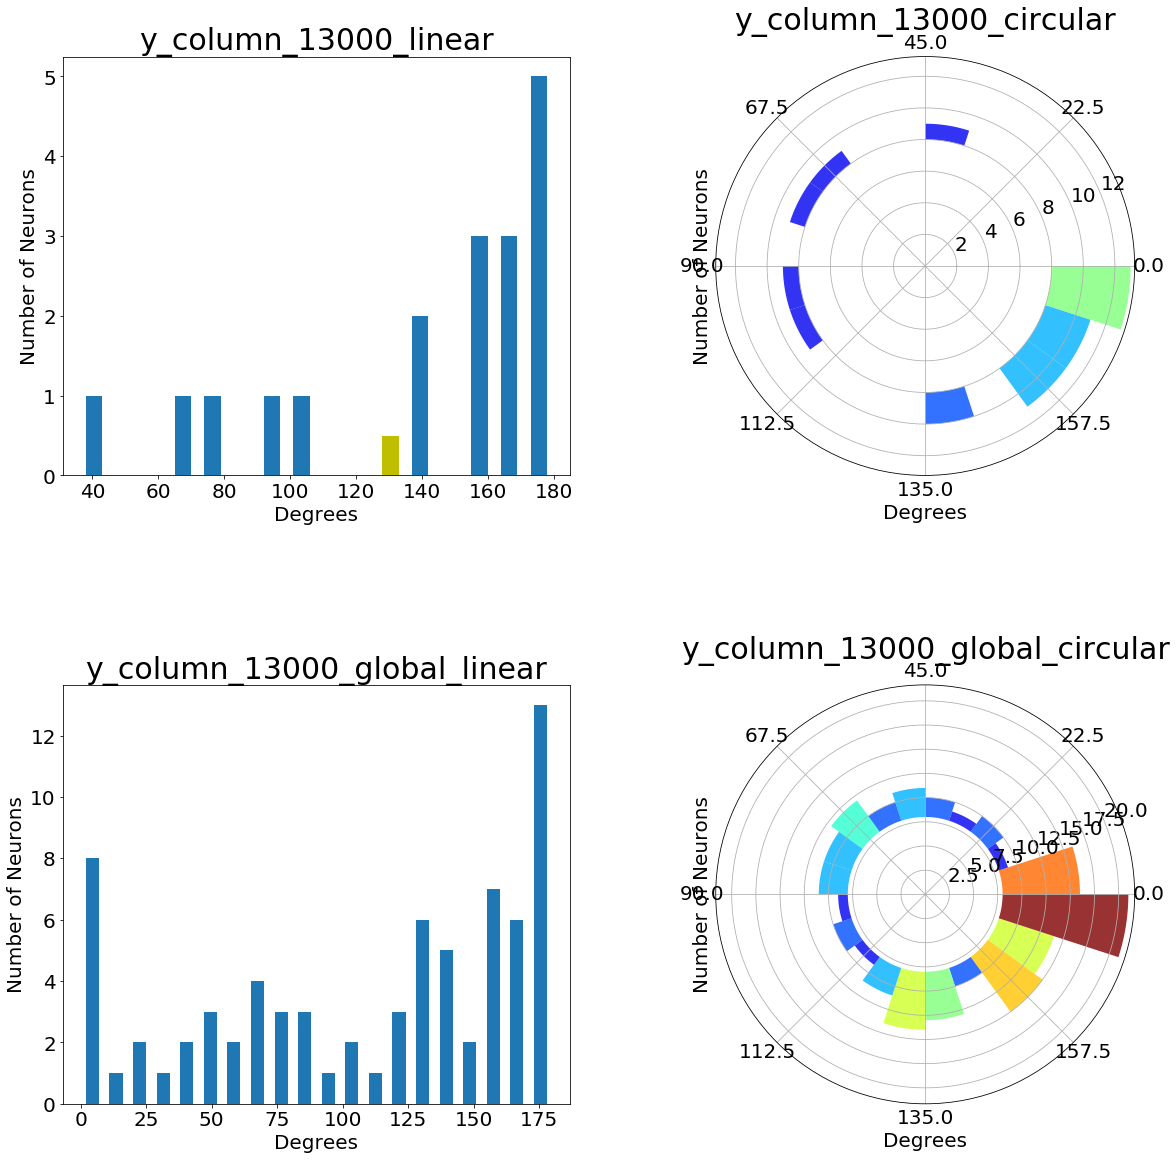

In [25]:
"""
Shows whole process of where start with a 

"""

#
target_neuron = 648518346341371119
target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]

"""
Example of how to find neurons within a certain radius
"""
total_neurons_list = list(soma_cell_location_dict.keys())
total_neurons_list.remove(target_neuron)

circular_radius = 15000 #test 1
circular_radius_neurons = [k for k in total_neurons_list if soma_distance_array[target_neuron][k]["distance"] < circular_radius ]
print("len(circular_radius_neurons) = " + str(len(circular_radius_neurons)))

"""
Example of how to find neurons within x column
"""

box_width = 13000
box_height = 13000
width_axis = "x_distance"
height_axis = "z_distance"

column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis]) < box_width)
                                                                      and (abs(soma_distance_array[target_neuron][k][height_axis]) < box_height))]

print("len(column_neurons) = " + str(len(column_neurons)))
print(column_neurons)

"""
Get the orientation distribution and difference in orientation distributions for a target neuron and it's restricted neighbors

This example shows the circular_radius_neurons
"""
global_neuron_group = total_neurons_list = list(soma_cell_location_dict.keys())
print("global_neuron_group = " + str(len(global_neuron_group)))
restricted_neuron_group = circular_radius_neurons
print("restricted_neuron_group = " + str(len(restricted_neuron_group)))

#get the orientations of these groups
restricted_neuron_group_orientations = [seg_id_to_orientation[k] for k in restricted_neuron_group] #NOT INCLUDE TARGET NEURON

global_neuron_group_orientations = [seg_id_to_orientation[k] for k in global_neuron_group] # DOES INCLUDE TARGET NEURON


current_n_bins = 20
current_lower_bin_bound = 0
current_upper_bin_bound = np.pi

binned_angles,binned_angles_histogram = bin_orientation_data(restricted_neuron_group_orientations,
                                                         n_bins = current_n_bins,
                                                        lower_bin_bound = current_lower_bin_bound,
                                                         upper_bin_bound = current_upper_bin_bound)

global_binned_angles,global_binned_angles_histogram = bin_orientation_data(global_neuron_group_orientations,
                                                         n_bins = current_n_bins,
                                                        lower_bin_bound = current_lower_bin_bound,
                                                         upper_bin_bound = current_upper_bin_bound)

interest_binned_angles,interest_binned_angles_histogram = bin_orientation_data([target_neuron_orientation_preferene],
                                                        n_bins = current_n_bins,
                                                        lower_bin_bound = current_lower_bin_bound,
                                                         upper_bin_bound = current_upper_bin_bound)

#print(interest_binned_angles)

graph_binned_orientation_data(binned_angles,
                                binned_angles_histogram,
                                  neuron_id=target_neuron,
                                  title="y_column_"+str(box_width),
                              n_bins=current_n_bins,
                              global_binned_angles = global_binned_angles,
                                global_binned_angles_histogram= global_binned_angles_histogram,
                                 graphs_to_plot=["local","global"],
                                 figure_size = (20,20),
                                 circular_flag = True,
                                 target_neuron_orientation = interest_binned_angles)




# Getting the Axis Dimensions (for same volume or same number)

In [30]:
#original volume dimensions
x_box = 250000
y_box = 140000
z_box = 90000


# test 2 (more strict to try and keep around 10 neurons for at least 90 %)
y_width = y_height = 6600
z_width = z_height = 11900
x_width = x_height = 2850
circular_radius = 13700

# calculate the total volume for certain parameters
y_col_volume = (2*y_width) * (2*y_height) * y_box
x_col_volume = (2*x_width) * (2*x_height) * x_box
z_col_volume = (2*z_width) * (2*z_height) * z_box
sphere_volume = 4.0/3.0*np.pi*(circular_radius**3)

print(f"y_col_volume = {y_col_volume} \
\nx_col_volume = {x_col_volume}\
\nz_col_volume = {z_col_volume}\
\nsphere_volume = {sphere_volume}")


print("\n\nThe relative scaling")
print(f"y_col_volume = {y_col_volume/sphere_volume} \
\nx_col_volume = {x_col_volume/sphere_volume}\
\nz_col_volume = {z_col_volume/sphere_volume}\
\nsphere_volume = {sphere_volume/sphere_volume}")

# find scaling factors to make everyone the same volume
def get_extra_width(final_volume,current_height,current_width):
    extra_width = np.sqrt((final_volume)/current_height)/2 - current_width
    return extra_width
#     if extra_width < 0:
#         return - np.sqrt(np.abs(extra_width))
#     else:
#         return np.sqrt(np.abs(extra_width))
    

y_extra_width = get_extra_width(sphere_volume,y_box,y_width)
#check that the height will now be the same
y_new_width = y_width + y_extra_width


x_extra_width = get_extra_width(sphere_volume,x_box,x_width)
#check that the height will now be the same
x_new_width = x_width + x_extra_width

z_extra_width = get_extra_width(sphere_volume,z_box,z_width)
#check that the height will now be the same
z_new_width = z_width + z_extra_width

"""
4*w*h*box + 8*extra*h*ybox + 4*extra^2*y_box = new_volume
8*extra*width + 4*extra**2 = (new_volum - current_volume)/y_box

"""

print("\n New volume scales")
y_col_volume_new = (2*y_new_width) * (2*y_new_width) * y_box
z_col_volume_new = (2*z_new_width) * (2*z_new_width) * z_box
x_col_volume_new = (2*x_new_width) * (2*x_new_width) * x_box
print(y_col_volume_new/sphere_volume,z_col_volume_new/sphere_volume,x_col_volume_new/sphere_volume)

print("\n New widths for exact same volume")
print("y_new_width = " + str(y_new_width))
print("z_new_width = " + str(z_new_width))
print("x_new_width = " + str(x_new_width))

# How could we add different scaling to make sure holds true
scale_factor = 2
circular_radius_scaled = (scale_factor**(1/3))*circular_radius
y_new_width_scaled = (scale_factor**(1/2))*y_new_width
z_new_width_scaled = (scale_factor**(1/2))*z_new_width
x_new_width_scaled = (scale_factor**(1/2))*x_new_width

y_col_volume_scaled = (2*y_new_width_scaled) * (2*y_new_width_scaled) * y_box
z_col_volume_scaled = (2*z_new_width_scaled) * (2*z_new_width_scaled) * z_box
x_col_volume_scaled = (2*x_new_width_scaled) * (2*x_new_width_scaled) * x_box
sphere_volume_scaled = (4.0/3.0)*np.pi*(circular_radius_scaled**3)

print("\n New widths and radius SCALED by factor of " + str(scale_factor))
print("y_new_width_scaled = " + str(y_new_width_scaled))
print("z_new_width_scaled = " + str(z_new_width_scaled))
print("x_new_width_scaled = " + str(x_new_width_scaled))
print("circular_radius_scaled = " + str(circular_radius_scaled))

print(y_col_volume_scaled/sphere_volume_scaled,z_col_volume_scaled/sphere_volume_scaled,x_col_volume_scaled/sphere_volume_scaled)

scale_factor = 4
circular_radius_scaled = (scale_factor**(1/3))*circular_radius
y_new_width_scaled = (scale_factor**(1/2))*y_new_width
z_new_width_scaled = (scale_factor**(1/2))*z_new_width
x_new_width_scaled = (scale_factor**(1/2))*x_new_width

print("\n New widths and radius SCALED by factor of " + str(scale_factor))
print("y_new_width_scaled = " + str(y_new_width_scaled))
print("z_new_width_scaled = " + str(z_new_width_scaled))
print("x_new_width_scaled = " + str(x_new_width_scaled))
print("circular_radius_scaled = " + str(circular_radius_scaled))


y_col_volume = 24393600000000 
x_col_volume = 8122500000000
z_col_volume = 50979600000000
sphere_volume = 10770858259448.1


The relative scaling
y_col_volume = 2.26477773752172 
x_col_volume = 0.7541181774326123
z_col_volume = 4.733104713849628
sphere_volume = 1.0

 New volume scales
1.0000000000000002 0.9999999999999998 1.0

 New widths for exact same volume
y_new_width = 4385.621445508057
z_new_width = 5469.83095905981
x_new_width = 3281.8985754358864

 New widths and radius SCALED by factor of 2
y_new_width_scaled = 6202.2053276717925
z_new_width_scaled = 7735.509126190617
x_new_width_scaled = 4641.305475714371
circular_radius_scaled = 17260.91838355976
1.0000000000000004 1.0 1.0000000000000004

 New widths and radius SCALED by factor of 4
y_new_width_scaled = 8771.242891016114
z_new_width_scaled = 10939.66191811962
x_new_width_scaled = 6563.797150871773
circular_radius_scaled = 21747.39441196433


In [33]:
"""Steps for analysis: For each neuron
    1) Get the subgroup (from columns or spheres), can adjust for the same number of neurons or same distance
    2) Calculate the average mse of the orientations of the subgroup from the neuron of interest (aka get the variance)
    3) Calculate the same thing as step 2 but with a random shuffle of neurons from outside the volume (repeat for lots of shuffles so get the distribution)
    4) Compare Step 2 and compute the probability of getting that from the distribution gotten in step 3
    Repeat 1- 4 for all neurons

Look at what the average probability is for all neurons and see if there is instane wher
    
    
mse from the columns

keep the column heights and sphere volume the same"""
import time
import random
def calc_mse(restricted_neuron_group,
             target_scaled
            ):
    
    restricted_neuron_group_orientation_preference = np.array([seg_id_to_orientation[k] for k in restricted_neuron_group])

    #now to get the total list shifted by subtracting off the target neuron
    total_neurons_scaled = restricted_neuron_group_orientation_preference*2

    differences = pycs.pairwise_cdiff(total_neurons_scaled,target_scaled)/2
    squared_difference = np.mean(differences**2)
    
    return squared_difference

mse_data = dict()
#target_neuron = 648518346341371119
start_time = time.time()
for target_neuron in soma_cell_location_dict.keys():
    

    mse_data[target_neuron] = dict()

    target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


    target_scaled = target_neuron_orientation_preferene*2
    """
    Example of how to find neurons within a certain radius
    """
    total_neurons_list = list(soma_cell_location_dict.keys())
    total_neurons_list.remove(target_neuron)

    """
    Example of how to find neurons within x column
    """

    # test 1
    y_width = y_height = 11000
    z_width = z_height = 11000
    x_width = x_height = 11000
    circular_radius = 13000
    
    # test 2 (more strict to try and keep around 10 neurons for at least 90 %)
    y_width = y_height = 6600
    z_width = z_height = 11900
    x_width = x_height = 2850
    circular_radius = 13700
    
    #test 3 (with equal volume) 
    y_new_width = 4385.621445508057
    z_new_width = 5469.83095905981
    x_new_width = 3281.8985754358864
    
    y_width = y_height = y_new_width
    z_width = z_height = z_new_width
    x_width = x_height = x_new_width
    
    #test 4 (scaled by 2 with equal volume)
    y_new_width_scaled = 6202.2053276717925
    z_new_width_scaled = 7735.509126190617
    x_new_width_scaled = 4641.305475714371
    circular_radius_scaled = 17260.91838355976
    
    y_width = y_height = y_new_width_scaled
    z_width = z_height = z_new_width_scaled
    x_width = x_height = x_new_width_scaled
    circular_radius = circular_radius_scaled
    
    # test 5
    #New widths and radius SCALED by factor of 0.5
    y_new_width_scaled = 3101.1026638358962
    z_new_width_scaled = 3867.7545630953086
    x_new_width_scaled = 2320.6527378571855
    circular_radius_scaled = 10873.697205982167
    
    y_width = y_height = y_new_width_scaled
    z_width = z_height = z_new_width_scaled
    x_width = x_height = x_new_width_scaled
    circular_radius = circular_radius_scaled
    
    # test 2 (more strict to try and keep around 10 neurons for at least 90 %)
    y_width = y_height = 6600
    z_width = z_height = 11900
    x_width = x_height = 2850
    circular_radius = 13700
    
    width_axis = "x_distance"; height_axis = "z_distance"
    y_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,y_width,y_height)

    
    width_axis = "x_distance"; height_axis = "y_distance"
    z_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,z_width,z_height)

    
    width_axis = "y_distance"; height_axis = "z_distance"
    x_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,x_width,x_height)

    
    circular_subgroup = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius)


    subgroups_list = dict(y_column_subgroup=y_column_subgroup,
                         z_column_subgroup=z_column_subgroup,
                         x_column_subgroup=x_column_subgroup,
                         circular_subgroup=circular_subgroup)

    n_random_shuffles = 1000


    
    for subgroup_name,restricted_neuron_group in subgroups_list.items():
        #get the mse of that subgroup
        restricted_neuron_group_mse = calc_mse(restricted_neuron_group,
                                              target_scaled)
        outside_neurons = [k for k in total_neurons_list if 
                       ((k not in restricted_neuron_group) and 
                        k != target_neuron)]
#         print("len(restricted_neuron_group) = " + str(len(restricted_neuron_group)))
#         print("len(outside_neurons) = " + str(len(outside_neurons)))
        
        random_shuffles_mse = []
        for i in range(0,n_random_shuffles):
            #get a random list from outside the subgroup
            if len(restricted_neuron_group) < len(outside_neurons):
                outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
            else:
                if i == 1:
                    print("not using sampling")
                outside_neurons_rand = outside_neurons
            
            if len(restricted_neuron_group) < len(outside_neurons_rand):
                print("RESTRICTED GROUP NUMBER IS LESS")
            random_shuffles_mse.append(calc_mse(outside_neurons_rand,
                                              target_scaled))

        #save the random shuffles
        mse_data[target_neuron][subgroup_name] = dict() 
        mse_data[target_neuron][subgroup_name]["shuffles"] = random_shuffles_mse
        mse_data[target_neuron][subgroup_name]["real_group"] = restricted_neuron_group_mse
        mse_data[target_neuron][subgroup_name]["real_group_len"] = len(restricted_neuron_group)
        
        probability_less_than = np.sum(random_shuffles_mse<restricted_neuron_group_mse)/len(random_shuffles_mse)
        mse_data[target_neuron][subgroup_name]["probability"] = probability_less_than
print(f"Total time for neurons = " + str(time.time() - start_time))

Total time for neurons = 22.446999311447144


Text(0.5, 1.0, 'Total probability distributions\nx_width = 2850, x_height = 2850\ny_width = 6600, y_height = 6600\nz_width = 11900, z_height = 11900\ncircular_radius = 13700\nmean subgroup number = 15.86\nstd dev subgroup number = 5.344\n Mean probability = 0.49')

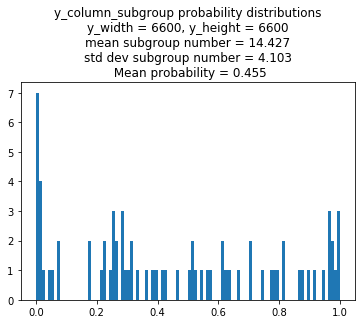

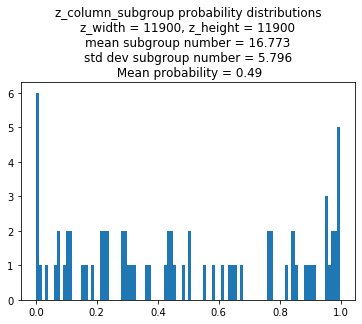

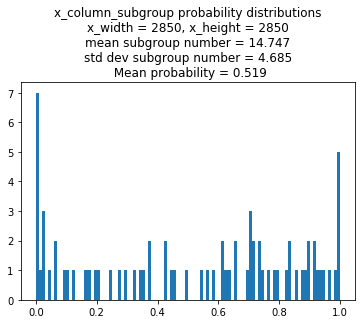

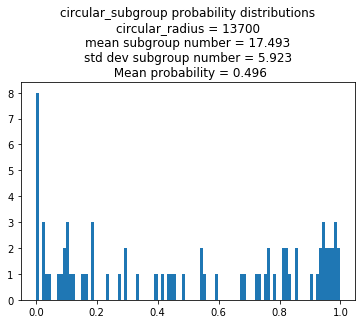

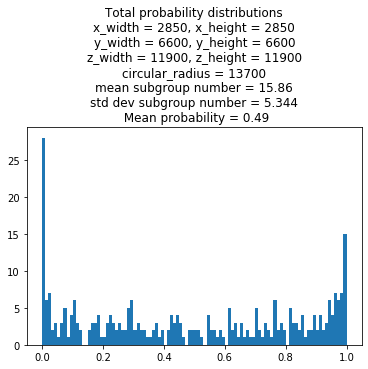

In [34]:

x_parameter_string = f"x_width = {x_width}, x_height = {x_height}"
y_parameter_string = f"y_width = {y_width}, y_height = {y_height}"
z_parameter_string = f"z_width = {z_width}, z_height = {z_height}"
sphere_parameter_string = f"circular_radius = {circular_radius}"


whole_parameters_string = "\n"+x_parameter_string+ \
                            "\n"+y_parameter_string+ \
                            "\n"+z_parameter_string+ \
                            "\n"+sphere_parameter_string

parameter_strings = [y_parameter_string,z_parameter_string,x_parameter_string,
                    sphere_parameter_string]

whole_parameters_string

#get all of the probabilities for each group

column_sphere_names = subgroups_list.keys()
total_probabilities = []
total_group_number = []
column_sphere_subgroup_number = dict()
column_sphere_probabilities = dict()
for volume_name,param in zip(column_sphere_names,parameter_strings):
    column_sphere_probabilities[volume_name] = []
    column_sphere_subgroup_number[volume_name] = []
    for a in mse_data.keys():
            column_sphere_probabilities[volume_name].append(mse_data[a][volume_name]["probability"])
            column_sphere_subgroup_number[volume_name].append(mse_data[a][volume_name]["real_group_len"])
    plt.figure()
    plt.hist(column_sphere_probabilities[volume_name],bins=100)
    mean_group_number = np.mean(column_sphere_subgroup_number[volume_name])
    std_dev_group_number = np.std(column_sphere_subgroup_number[volume_name])
    plt.title(volume_name  + " probability distributions\n" + param 
                           + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                           + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                            + "\n Mean probability = " + str(np.round(np.mean(column_sphere_probabilities[volume_name]),3)))
    total_group_number += column_sphere_subgroup_number[volume_name]
    total_probabilities += column_sphere_probabilities[volume_name]
    
    
mean_group_number = np.mean(total_group_number)
std_dev_group_number = np.std(total_group_number)

plt.figure()
plt.hist(total_probabilities,bins=100)
plt.title("Total probability distributions" + whole_parameters_string
         + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
         + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
         + "\n Mean probability = " + str(np.round(np.mean(total_probabilities),3)))

# !!!!!!!!!!!------ Step Through the MSE Calculations to Make sure they are correct --------

******* STARTING ON NEW NEURON *******************
restricted_neuron_group_mse for group y_column_subgroup = 0.771130228099056
probability_less_than for group y_column_subgroup = 0.873
restricted_neuron_group_mse for group z_column_subgroup = 0.5487916503290214
probability_less_than for group z_column_subgroup = 0.083
restricted_neuron_group_mse for group x_column_subgroup = 0.5792652266677162
probability_less_than for group x_column_subgroup = 0.19
restricted_neuron_group_mse for group circular_subgroup = 0.57114358821032
probability_less_than for group circular_subgroup = 0.082
Total time for neurons = 0.5593380928039551


'\nrestricted_neuron_group_mse for group y_column_subgroup = 0.771130228099056\nprobability_less_than for group y_column_subgroup = 0.862\nrestricted_neuron_group_mse for group z_column_subgroup = 0.5487916503290214\nprobability_less_than for group z_column_subgroup = 0.098\nrestricted_neuron_group_mse for group x_column_subgroup = 0.5792652266677162\nprobability_less_than for group x_column_subgroup = 0.175\nrestricted_neuron_group_mse for group circular_subgroup = 0.57114358821032\nprobability_less_than for group circular_subgroup = 0.09\n'

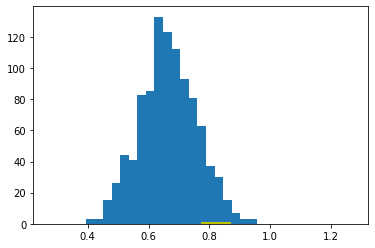

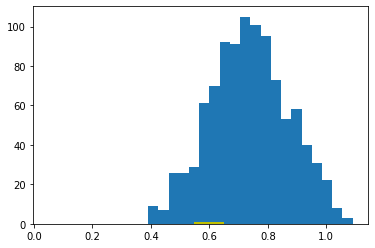

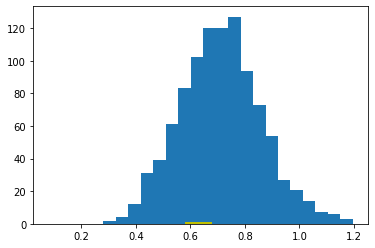

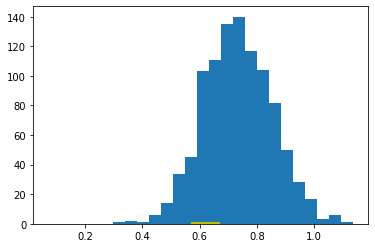

In [54]:
"""Steps for analysis: For each neuron
    1) Get the subgroup (from columns or spheres), can adjust for the same number of neurons or same distance
    2) Calculate the average mse of the orientations of the subgroup from the neuron of interest (aka get the variance)
    3) Calculate the same thing as step 2 but with a random shuffle of neurons from outside the volume (repeat for lots of shuffles so get the distribution)
    4) Compare Step 2 and compute the probability of getting that from the distribution gotten in step 3
    Repeat 1- 4 for all neurons

Look at what the average probability is for all neurons and see if there is instane wher
    
    
mse from the columns

keep the column heights and sphere volume the same"""
import time
import random
def calc_mse(restricted_neuron_group,
             target_scaled
            ):
    
    restricted_neuron_group_orientation_preference = np.array([seg_id_to_orientation[k] for k in restricted_neuron_group])

    #now to get the total list shifted by subtracting off the target neuron
    total_neurons_scaled = restricted_neuron_group_orientation_preference*2

    differences = pycs.pairwise_cdiff(total_neurons_scaled,target_scaled)/2
    squared_difference = np.mean(differences**2)
    
    return squared_difference

mse_data = dict()
#target_neuron = 648518346341371119
start_time = time.time()

for i,target_neuron in enumerate(soma_cell_location_dict.keys()):
    print("******* STARTING ON NEW NEURON *******************")
    

    mse_data[target_neuron] = dict()

    target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


    target_scaled = target_neuron_orientation_preferene*2
    """
    Example of how to find neurons within a certain radius
    """
    total_neurons_list = list(soma_cell_location_dict.keys())
    total_neurons_list.remove(target_neuron)

    """
    Example of how to find neurons within x column
    """
    
    # test 2 (more strict to try and keep around 10 neurons for at least 90 %)
    y_width = y_height = 6600
    z_width = z_height = 11900
    x_width = x_height = 2850
    circular_radius = 13700
    
    
    width_axis = "x_distance"; height_axis = "z_distance"
    y_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,y_width,y_height)
    y_column_orientation_preferences = [seg_id_to_orientation[k] for k in y_column_subgroup]
    y_soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in y_column_subgroup])
    
    
    width_axis = "x_distance"; height_axis = "y_distance"
    z_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,z_width,z_height)
    z_column_orientation_preferences = [seg_id_to_orientation[k] for k in z_column_subgroup]
    z_soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in z_column_subgroup])

    
    width_axis = "y_distance"; height_axis = "z_distance"
    x_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,x_width,x_height)
    x_column_orientation_preferences = [seg_id_to_orientation[k] for k in x_column_subgroup]
    x_soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in x_column_subgroup])

    
    #visualize the groups to make sure correct:
    target_cell_location = soma_cell_location_dict[target_neuron]["location"]
    


    

    # The graphhing looks a little off because the Z axis is smaller than the rest and throws things off
    
    circular_subgroup = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius)
    radius_column_orientation_preferences = [seg_id_to_orientation[k] for k in circular_subgroup]
    radius_soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in circular_subgroup])
    
#     print_3D_visuals(radius_soma_centers_list,radius_column_orientation_preferences,target_neuron,target_neuron_orientation_preferene)
#     print_3D_visuals(x_soma_centers_list,x_column_orientation_preferences,target_neuron,target_neuron_orientation_preferene)
#     print_3D_visuals(y_soma_centers_list,y_column_orientation_preferences,target_neuron,target_neuron_orientation_preferene)
#     print_3D_visuals(z_soma_centers_list,z_column_orientation_preferences,target_neuron,target_neuron_orientation_preferene)


    subgroups_list = dict(y_column_subgroup=y_column_subgroup,
                         z_column_subgroup=z_column_subgroup,
                         x_column_subgroup=x_column_subgroup,
                         circular_subgroup=circular_subgroup)

    n_random_shuffles = 1000


    
    for subgroup_name,restricted_neuron_group in subgroups_list.items():
        #get the mse of that subgroup
        restricted_neuron_group_mse = calc_mse(restricted_neuron_group,
                                              target_scaled)
        outside_neurons = [k for k in total_neurons_list if 
                       ((k not in restricted_neuron_group) and 
                        (k != target_neuron))]
#         print("len(restricted_neuron_group) = " + str(len(restricted_neuron_group)))
#         print("len(outside_neurons) = " + str(len(outside_neurons)))
        
        random_shuffles_mse = []
        for i in range(0,n_random_shuffles):
            #get a random list from outside the subgroup
            if len(restricted_neuron_group) < len(outside_neurons):
                outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
            else:
                if i == 1:
                    print("not using sampling")
                outside_neurons_rand = outside_neurons
            
            if len(restricted_neuron_group) < len(outside_neurons_rand):
                print("RESTRICTED GROUP NUMBER IS LESS")
            random_shuffles_mse.append(calc_mse(outside_neurons_rand,
                                              target_scaled))

        #save the random shuffles
        mse_data[target_neuron][subgroup_name] = dict() 
        mse_data[target_neuron][subgroup_name]["shuffles"] = random_shuffles_mse
        mse_data[target_neuron][subgroup_name]["real_group"] = restricted_neuron_group_mse
        mse_data[target_neuron][subgroup_name]["real_group_len"] = len(restricted_neuron_group)
        
        probability_less_than = np.sum(random_shuffles_mse<restricted_neuron_group_mse)/len(random_shuffles_mse)
        mse_data[target_neuron][subgroup_name]["probability"] = probability_less_than
        
        #plot the distribution
        print(f"restricted_neuron_group_mse for group {subgroup_name} = " + str(restricted_neuron_group_mse))
        print(f"probability_less_than for group {subgroup_name} = " + str(probability_less_than))
        plt.figure()
        plt.hist(random_shuffles_mse,bins=20)
        plt.hist(restricted_neuron_group_mse,color="y")
    break
print(f"Total time for neurons = " + str(time.time() - start_time))

"""
restricted_neuron_group_mse for group y_column_subgroup = 0.771130228099056
probability_less_than for group y_column_subgroup = 0.862
restricted_neuron_group_mse for group z_column_subgroup = 0.5487916503290214
probability_less_than for group z_column_subgroup = 0.098
restricted_neuron_group_mse for group x_column_subgroup = 0.5792652266677162
probability_less_than for group x_column_subgroup = 0.175
restricted_neuron_group_mse for group circular_subgroup = 0.57114358821032
probability_less_than for group circular_subgroup = 0.09
"""

# Do the same probability analysis for only neurons with orientations with certain preference

In [55]:
mse_radian_subgroup = dict()
window_size_degrees = 180/16/2
window_size_radians = window_size_degrees/rad2deg*4

#how the radians will move when graphing them
n_window_samples = 50
window_radians_stepsize = np.pi/n_window_samples

total_center_radians = np.linspace(0,np.pi,n_window_samples)

  0%|          | 0/50 [00:00<?, ?it/s]

(0.0014262787120165044, 3.1415783958709396)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in greater
  2%|▏         | 1/50 [00:10<08:16, 10.13s/it]

Total time for neurons = 10.090319156646729
(0.0014262787120165044, 3.1415783958709396)


  4%|▍         | 2/50 [00:19<07:58,  9.98s/it]

Total time for neurons = 9.58702301979065
(0.0014262787120165044, 3.1415783958709396)


  6%|▌         | 3/50 [00:28<07:33,  9.64s/it]

Total time for neurons = 8.827588081359863
(0.0014262787120165044, 3.1415783958709396)


  8%|▊         | 4/50 [00:37<07:07,  9.29s/it]

Total time for neurons = 8.435107231140137
(0.0014262787120165044, 3.1415783958709396)


 10%|█         | 5/50 [00:44<06:38,  8.85s/it]

Total time for neurons = 7.804336071014404
(0.0014262787120165044, 3.1415783958709396)


 12%|█▏        | 6/50 [00:51<05:59,  8.16s/it]

Total time for neurons = 6.517922639846802
(0.0014262787120165044, 3.1415783958709396)


 14%|█▍        | 7/50 [00:55<05:02,  7.04s/it]

Total time for neurons = 4.374742269515991
(0.07589504939179825, 0.7412647965473007)


 16%|█▌        | 8/50 [00:58<03:59,  5.70s/it]

Total time for neurons = 2.5434482097625732
(0.236372735426882, 0.8642521489789932)


 18%|█▊        | 9/50 [01:00<03:11,  4.67s/it]

Total time for neurons = 2.2631287574768066
(0.236372735426882, 0.9437451102943939)


 20%|██        | 10/50 [01:03<02:45,  4.13s/it]

Total time for neurons = 2.838548421859741
(0.36382762867534924, 0.9437451102943939)


 22%|██▏       | 11/50 [01:06<02:22,  3.66s/it]

Total time for neurons = 2.5600059032440186
(0.36382762867534924, 1.0692007677779636)


 24%|██▍       | 12/50 [01:09<02:10,  3.42s/it]

Total time for neurons = 2.8321681022644043
(0.39215289534564945, 1.1361967147164682)


 26%|██▌       | 13/50 [01:11<02:00,  3.24s/it]

Total time for neurons = 2.807516574859619
(0.4836684389739436, 1.203659674993054)


 28%|██▊       | 14/50 [01:15<01:59,  3.31s/it]

Total time for neurons = 3.434290647506714
(0.6617509902152738, 1.28992258725774)


 30%|███       | 15/50 [01:18<01:55,  3.31s/it]

Total time for neurons = 3.3038747310638428
(0.6617509902152738, 1.309220004964577)


 32%|███▏      | 16/50 [01:22<01:55,  3.40s/it]

Total time for neurons = 3.570669412612915
(0.6617509902152738, 1.3918713381558774)


 34%|███▍      | 17/50 [01:26<01:57,  3.56s/it]

Total time for neurons = 3.918840169906616
(0.7412647965473007, 1.3918713381558774)


 36%|███▌      | 18/50 [01:29<01:56,  3.64s/it]

Total time for neurons = 3.7858924865722656
(0.8519296426733858, 1.5095879882177234)


 38%|███▊      | 19/50 [01:33<01:52,  3.63s/it]

Total time for neurons = 3.5941250324249268
(0.8519296426733858, 1.5707955598460863)


 40%|████      | 20/50 [01:38<01:59,  4.00s/it]

Total time for neurons = 4.832381725311279
(0.9271866514840799, 1.6446010387351295)


 42%|████▏     | 21/50 [01:43<02:03,  4.24s/it]

Total time for neurons = 4.786646127700806
(1.0692007677779636, 1.6446010387351295)


 44%|████▍     | 22/50 [01:46<01:53,  4.04s/it]

Total time for neurons = 3.544589042663574
(1.0692007677779636, 1.744054846174147)


 46%|████▌     | 23/50 [01:51<01:53,  4.21s/it]

Total time for neurons = 4.570847034454346
(1.1361967147164682, 1.8403989758208645)


 48%|████▊     | 24/50 [01:55<01:48,  4.15s/it]

Total time for neurons = 4.007207870483398
(1.1780995358311086, 1.8403989758208645)


 50%|█████     | 25/50 [01:58<01:38,  3.94s/it]

Total time for neurons = 3.4266088008880615
(1.28992258725774, 1.8403989758208645)


 52%|█████▏    | 26/50 [02:01<01:24,  3.54s/it]

Total time for neurons = 2.5669050216674805
(1.28992258725774, 1.9971308649498853)


 54%|█████▍    | 27/50 [02:04<01:17,  3.37s/it]

Total time for neurons = 2.9649345874786377
(1.3918713381558774, 1.9971308649498853)


 56%|█████▌    | 28/50 [02:06<01:08,  3.10s/it]

Total time for neurons = 2.4408748149871826
(1.5095879882177234, 2.166493900205718)


 58%|█████▊    | 29/50 [02:09<01:03,  3.02s/it]

Total time for neurons = 2.8098526000976562
(1.5095879882177234, 2.205241588848084)


 60%|██████    | 30/50 [02:13<01:03,  3.16s/it]

Total time for neurons = 3.462843656539917
(1.562573677956026, 2.3139529824921334)


 62%|██████▏   | 31/50 [02:17<01:06,  3.52s/it]

Total time for neurons = 4.318794012069702
(1.6446010387351295, 2.3679265497261794)


 64%|██████▍   | 32/50 [02:21<01:07,  3.76s/it]

Total time for neurons = 4.317238807678223
(1.744054846174147, 2.4022901798731917)


 66%|██████▌   | 33/50 [02:26<01:07,  3.97s/it]

Total time for neurons = 4.434086799621582
(1.744054846174147, 2.4816825297740817)


 68%|██████▊   | 34/50 [02:31<01:06,  4.16s/it]

Total time for neurons = 4.563710689544678
(1.8403989758208645, 2.4816825297740817)


 70%|███████   | 35/50 [02:35<01:03,  4.22s/it]

Total time for neurons = 4.341079473495483
(1.9971308649498853, 2.6328612397986317)


 72%|███████▏  | 36/50 [02:39<00:59,  4.29s/it]

Total time for neurons = 4.319606781005859
(1.9971308649498853, 2.674240652364497)


 74%|███████▍  | 37/50 [02:44<00:58,  4.50s/it]

Total time for neurons = 4.983721017837524
(1.9971308649498853, 2.7603252861926446)


 76%|███████▌  | 38/50 [02:50<00:59,  4.97s/it]

Total time for neurons = 6.026292562484741
(2.1460737335999718, 2.817706161369581)


 78%|███████▊  | 39/50 [02:57<00:59,  5.44s/it]

Total time for neurons = 6.500421762466431
(2.1460737335999718, 2.889046290288316)


 80%|████████  | 40/50 [03:05<01:01,  6.19s/it]

Total time for neurons = 7.910245418548584
(2.1938769384356123, 2.9200734931775676)


 82%|████████▏ | 41/50 [03:12<00:57,  6.34s/it]

Total time for neurons = 6.67566704750061
(2.2771081356413223, 2.9992430280073377)


 84%|████████▍ | 42/50 [03:19<00:53,  6.66s/it]

Total time for neurons = 7.364724159240723
(2.302142659319062, 3.0811155452614933)


 86%|████████▌ | 43/50 [03:28<00:51,  7.36s/it]

Total time for neurons = 8.97139573097229
(0.0014262787120165044, 3.1415783958709396)


 88%|████████▊ | 44/50 [03:37<00:47,  7.94s/it]

Total time for neurons = 9.23647665977478
(0.0014262787120165044, 3.1415783958709396)


 90%|█████████ | 45/50 [03:47<00:42,  8.48s/it]

Total time for neurons = 9.707130432128906
(0.0014262787120165044, 3.1415783958709396)


 92%|█████████▏| 46/50 [03:57<00:36,  9.02s/it]

Total time for neurons = 10.266124248504639
(0.0014262787120165044, 3.1415783958709396)


 94%|█████████▍| 47/50 [04:08<00:28,  9.39s/it]

Total time for neurons = 10.199923276901245
(0.0014262787120165044, 3.1415783958709396)


 96%|█████████▌| 48/50 [04:18<00:19,  9.77s/it]

Total time for neurons = 10.612216711044312
(0.0014262787120165044, 3.1415783958709396)


 98%|█████████▊| 49/50 [04:28<00:09,  9.69s/it]

Total time for neurons = 9.49611783027649
(0.0014262787120165044, 3.1415783958709396)


100%|██████████| 50/50 [04:37<00:00,  5.56s/it]

Total time for neurons = 9.581645488739014


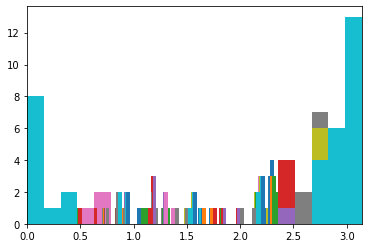

In [56]:
#-------------------starting loop through all middle orientations-----------------------#




for middle_orientation in tqdm(total_center_radians):
    mse_radian_subgroup[middle_orientation] = dict()

    #print(f"Radians range = {(middle_orientation - window_size_radians,middle_orientation + window_size_radians)}")

    #get the orientation differences of all
    target_neurons_to_iterate_through = [k for k in soma_cell_location_dict.keys() if 
                                         np.abs(pycs.cdiff(seg_id_to_orientation[k]*2,middle_orientation*2)/2) < window_size_radians]

    #print("len(target_neurons_to_iterate_through) = " + str(len(target_neurons_to_iterate_through)))
    mse_radian_subgroup[middle_orientation]["neuron_number"] = len(target_neurons_to_iterate_through)

    #checking that correctly getting the subgroup
    orientations_neurons_to_iterate_through = [seg_id_to_orientation[k] for k in target_neurons_to_iterate_through]
    x = plt.hist(orientations_neurons_to_iterate_through,bins=20)
    plt.xlim([0,np.pi])
    print((min(x[1]),max(x[1])))


    plotting = False

    mse_data = dict()
    #target_neuron = 648518346341371119
    start_time = time.time()

    for target_neuron in target_neurons_to_iterate_through:


        mse_data[target_neuron] = dict()

        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


        target_scaled = target_neuron_orientation_preferene*2
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)

        """
        Example of how to find neurons within x column
        """

        # test 1
        y_width = y_height = 11000
        z_width = z_height = 11000
        x_width = x_height = 11000
        circular_radius = 13000

        # test 2 (more strict to try and keep around 10 neurons for at least 90 %)
        y_width = y_height = 6600
        z_width = z_height = 11900
        x_width = x_height = 2850
        circular_radius = 13700

        #test 3 (with equal volume) 
        y_new_width = 4385.621445508057
        z_new_width = 5469.83095905981
        x_new_width = 3281.8985754358864

        y_width = y_height = y_new_width
        z_width = z_height = z_new_width
        x_width = x_height = x_new_width

    #     #test 4 (scaled by 2 with equal volume)
    #     y_new_width_scaled = 6202.2053276717925
    #     z_new_width_scaled = 7735.509126190617
    #     x_new_width_scaled = 4641.305475714371
    #     circular_radius_scaled = 17260.91838355976

    #     y_width = y_height = y_new_width_scaled
    #     z_width = z_height = z_new_width_scaled
    #     x_width = x_height = x_new_width_scaled
    #     circular_radius = circular_radius_scaled

    #     # test 5
    #     #New widths and radius SCALED by factor of 0.5
    #     y_new_width_scaled = 3101.1026638358962
    #     z_new_width_scaled = 3867.7545630953086
    #     x_new_width_scaled = 2320.6527378571855
    #     circular_radius_scaled = 10873.697205982167

    #     y_width = y_height = y_new_width_scaled
    #     z_width = z_height = z_new_width_scaled
    #     x_width = x_height = x_new_width_scaled
    #     circular_radius = circular_radius_scaled

        width_axis = "x_distance"; height_axis = "z_distance"
        y_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,y_width,y_height)


        width_axis = "x_distance"; height_axis = "y_distance"
        z_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,z_width,z_height)


        width_axis = "y_distance"; height_axis = "z_distance"
        x_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,x_width,x_height)


        circular_subgroup = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius)


        subgroups_list = dict(y_column_subgroup=y_column_subgroup,
                             z_column_subgroup=z_column_subgroup,
                             x_column_subgroup=x_column_subgroup,
                             circular_subgroup=circular_subgroup)

        n_random_shuffles = 1000



        for subgroup_name,restricted_neuron_group in subgroups_list.items():
            #get the mse of that subgroup
            restricted_neuron_group_mse = calc_mse(restricted_neuron_group,
                                                  target_scaled)
            outside_neurons = [k for k in total_neurons_list if 
                           ((k not in restricted_neuron_group) and 
                            k != target_neuron)]
    #         print("len(restricted_neuron_group) = " + str(len(restricted_neuron_group)))
    #         print("len(outside_neurons) = " + str(len(outside_neurons)))

            random_shuffles_mse = []
            for i in range(0,n_random_shuffles):
                #get a random list from outside the subgroup
                if len(restricted_neuron_group) < len(outside_neurons):
                    outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
                else:
                    if i == 1:
                        print("not using sampling")
                    outside_neurons_rand = outside_neurons

                if len(restricted_neuron_group) < len(outside_neurons_rand):
                    print("RESTRICTED GROUP NUMBER IS LESS")
                random_shuffles_mse.append(calc_mse(outside_neurons_rand,
                                                  target_scaled))

            #save the random shuffles
            mse_data[target_neuron][subgroup_name] = dict() 
            mse_data[target_neuron][subgroup_name]["shuffles"] = random_shuffles_mse
            mse_data[target_neuron][subgroup_name]["real_group"] = restricted_neuron_group_mse
            mse_data[target_neuron][subgroup_name]["real_group_len"] = len(restricted_neuron_group)

            probability_less_than = np.sum(random_shuffles_mse<restricted_neuron_group_mse)/len(random_shuffles_mse)
            mse_data[target_neuron][subgroup_name]["probability"] = probability_less_than
    print(f"Total time for neurons = " + str(time.time() - start_time))


    x_parameter_string = f"x_width = {x_width}, x_height = {x_height}"
    y_parameter_string = f"y_width = {y_width}, y_height = {y_height}"
    z_parameter_string = f"z_width = {z_width}, z_height = {z_height}"
    sphere_parameter_string = f"circular_radius = {circular_radius}"


    whole_parameters_string = "\n"+x_parameter_string+ \
                                "\n"+y_parameter_string+ \
                                "\n"+z_parameter_string+ \
                                "\n"+sphere_parameter_string

    parameter_strings = [y_parameter_string,z_parameter_string,x_parameter_string,
                        sphere_parameter_string]

    whole_parameters_string

    #get all of the probabilities for each group

    column_sphere_names = subgroups_list.keys()
    total_probabilities = []
    total_group_number = []
    column_sphere_subgroup_number = dict()
    column_sphere_probabilities = dict()
    for volume_name,param in zip(column_sphere_names,parameter_strings):
        column_sphere_probabilities[volume_name] = []
        column_sphere_subgroup_number[volume_name] = []
        for a in mse_data.keys():
                column_sphere_probabilities[volume_name].append(mse_data[a][volume_name]["probability"])
                column_sphere_subgroup_number[volume_name].append(mse_data[a][volume_name]["real_group_len"])
        mean_group_number = np.mean(column_sphere_subgroup_number[volume_name])
        std_dev_group_number = np.std(column_sphere_subgroup_number[volume_name])
        mean_probability = np.mean(column_sphere_probabilities[volume_name])
        if plotting:
            plt.figure()
            plt.hist(column_sphere_probabilities[volume_name],bins=100)

            plt.title(volume_name  + " probability distributions\n" + param 
                                   + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                                   + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                                    + "\n Mean probability = " + str(np.round(mean_probability,3)))

        #store the mean probability, subgroup number and std deviation in the largest dictionary so 
        # can compare as iterate over the radians
        mse_radian_subgroup[middle_orientation][volume_name] = dict(mean_group_number=mean_group_number,
                                                                   std_dev_group_number=std_dev_group_number,
                                                                   mean_probability=mean_probability)


        total_group_number += column_sphere_subgroup_number[volume_name]
        total_probabilities += column_sphere_probabilities[volume_name]


    mean_group_number = np.mean(total_group_number)
    std_dev_group_number = np.std(total_group_number)
    mean_probability = np.mean(total_probabilities)

    mse_radian_subgroup[middle_orientation]["total"] = dict(mean_group_number=mean_group_number,
                                                                   std_dev_group_number=std_dev_group_number,
                                                                   mean_probability=mean_probability)
    if plotting:
        plt.figure()
        plt.hist(total_probabilities,bins=100)
        plt.title("Total probability distributions" + whole_parameters_string
                 + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                 + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                 + "\n Mean probability = " + str(np.round(mean_probability,3)))

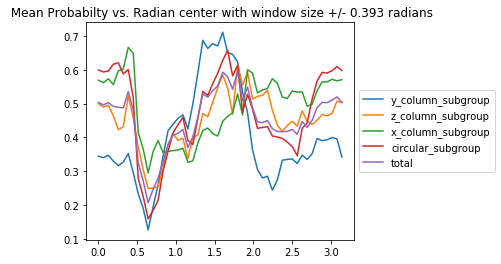

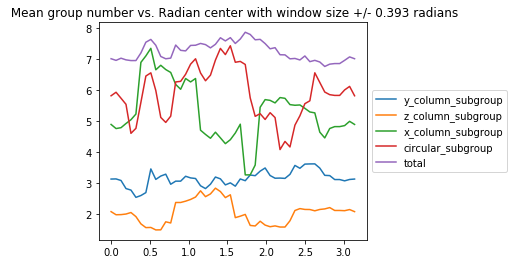

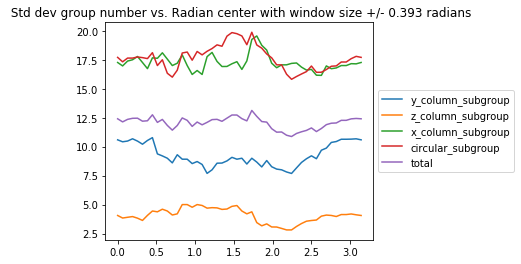

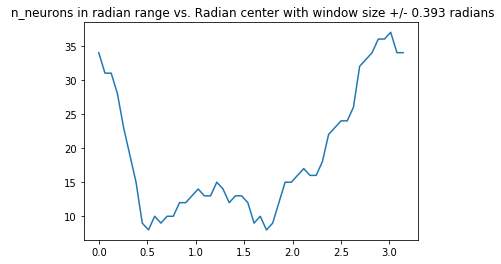

In [57]:
"""
Graphs want to do 
1) The mean probability of each group vs. center
2) The mean group number of each group vs. center
3) The std dev group number of each group vs. center
4) Number neurons that were tested in each radian group vs. center

"""

x = list(mse_radian_subgroup.keys())
column_type = list(mse_radian_subgroup[list(x)[0]].keys())
if "neuron_number" in column_type:
    column_type.remove("neuron_number")

#get the data for each column type
probability_data = dict()
std_dev_group_data = dict()
mean_group_data = dict()
for t in column_type:
    probability_data[t] = [v[t]["mean_probability"] for k,v in mse_radian_subgroup.items()]
    std_dev_group_data[t] = [v[t]["mean_group_number"] for k,v in mse_radian_subgroup.items()]
    mean_group_data[t] = [v[t]["std_dev_group_number"] for k,v in mse_radian_subgroup.items()]
    
#get the neuron number for each radian group
neuron_number_data = [mse_radian_subgroup[k]["neuron_number"] for k in mse_radian_subgroup.keys()]

window_size_radians_rounded = np.round(window_size_radians,3)
plt.figure()
plt.title(" Mean Probabilty vs. Radian center with window size +/- " + str(window_size_radians_rounded) + " radians")
for t,y in probability_data.items():
    plt.plot(x,y,label=t)
plt.legend()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

fig = plt.figure()

plt.title(" Mean group number vs. Radian center with window size +/- " + str(window_size_radians_rounded) + " radians")
for t,y in mean_group_data.items():
    plt.plot(x,y,label=t)
plt.legend()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

plt.figure()
plt.title(" Std dev group number vs. Radian center with window size +/- " + str(window_size_radians_rounded) + " radians")
for t,y in std_dev_group_data.items():
    plt.plot(x,y,label=t)
plt.legend()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

plt.figure()
plt.title(" n_neurons in radian range vs. Radian center with window size +/- " + str(window_size_radians_rounded) + " radians")
plt.plot(x,neuron_number_data)

In [58]:
# Iterating over differing the scale and seeing how that changes:
mse_scale_subgroup = dict()
n_window_samples = 20
total_scalings = np.linspace(0.25,4,n_window_samples)

In [59]:



#-------------------starting loop through all middle orientations-----------------------#
for scale_facotr in tqdm(total_scalings):
    mse_scale_subgroup[scale_facotr] = dict()


    plotting = False

    mse_data = dict()
    #target_neuron = 648518346341371119
    start_time = time.time()

    for target_neuron in soma_cell_location_dict.keys():


        mse_data[target_neuron] = dict()

        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


        target_scaled = target_neuron_orientation_preferene*2
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)

        """
        Example of how to find neurons within x column
        """

        # test 1
        y_width = y_height = 11000
        z_width = z_height = 11000
        x_width = x_height = 11000
        circular_radius = 13000

        # test 2 (more strict to try and keep around 10 neurons for at least 90 %)
        y_width = y_height = 6600
        z_width = z_height = 11900
        x_width = x_height = 2850
        circular_radius = 13700

        #test 3 (with equal volume) 
        y_new_width = 4385.621445508057
        z_new_width = 5469.83095905981
        x_new_width = 3281.8985754358864

        y_width = y_height = y_new_width
        z_width = z_height = z_new_width
        x_width = x_height = x_new_width

        
        circular_radius_scaled = (scale_factor**(1/3))*circular_radius
        y_new_width_scaled = (scale_factor**(1/2))*y_new_width
        z_new_width_scaled = (scale_factor**(1/2))*z_new_width
        x_new_width_scaled = (scale_factor**(1/2))*x_new_width

#         print("\n New widths and radius SCALED by factor of " + str(scale_factor))
#         print("y_new_width_scaled = " + str(y_new_width_scaled))
#         print("z_new_width_scaled = " + str(z_new_width_scaled))
#         print("x_new_width_scaled = " + str(x_new_width_scaled))
#         print("circular_radius_scaled = " + str(circular_radius_scaled))
        
        y_width = y_height = y_new_width_scaled
        z_width = z_height = z_new_width_scaled
        x_width = x_height = x_new_width_scaled
        circular_radius = circular_radius_scaled
        

        width_axis = "x_distance"; height_axis = "z_distance"
        y_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,y_width,y_height)


        width_axis = "x_distance"; height_axis = "y_distance"
        z_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,z_width,z_height)


        width_axis = "y_distance"; height_axis = "z_distance"
        x_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,x_width,x_height)


        circular_subgroup = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius)


        subgroups_list = dict(y_column_subgroup=y_column_subgroup,
                             z_column_subgroup=z_column_subgroup,
                             x_column_subgroup=x_column_subgroup,
                             circular_subgroup=circular_subgroup)

        n_random_shuffles = 1000



        for subgroup_name,restricted_neuron_group in subgroups_list.items():
            #get the mse of that subgroup
            restricted_neuron_group_mse = calc_mse(restricted_neuron_group,
                                                  target_scaled)
            outside_neurons = [k for k in total_neurons_list if 
                           ((k not in restricted_neuron_group) and 
                            k != target_neuron)]
    #         print("len(restricted_neuron_group) = " + str(len(restricted_neuron_group)))
    #         print("len(outside_neurons) = " + str(len(outside_neurons)))

            random_shuffles_mse = []
            for i in range(0,n_random_shuffles):
                #get a random list from outside the subgroup
                if len(restricted_neuron_group) < len(outside_neurons):
                    outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
                else:
                    if i == 1:
                        print("not using sampling")
                    outside_neurons_rand = outside_neurons

                if len(restricted_neuron_group) < len(outside_neurons_rand):
                    print("RESTRICTED GROUP NUMBER IS LESS")
                random_shuffles_mse.append(calc_mse(outside_neurons_rand,
                                                  target_scaled))

            #save the random shuffles
            mse_data[target_neuron][subgroup_name] = dict() 
            mse_data[target_neuron][subgroup_name]["shuffles"] = random_shuffles_mse
            mse_data[target_neuron][subgroup_name]["real_group"] = restricted_neuron_group_mse
            mse_data[target_neuron][subgroup_name]["real_group_len"] = len(restricted_neuron_group)

            probability_less_than = np.sum(random_shuffles_mse<restricted_neuron_group_mse)/len(random_shuffles_mse)
            mse_data[target_neuron][subgroup_name]["probability"] = probability_less_than
    print(f"Total time for neurons = " + str(time.time() - start_time))


    x_parameter_string = f"x_width = {x_width}, x_height = {x_height}"
    y_parameter_string = f"y_width = {y_width}, y_height = {y_height}"
    z_parameter_string = f"z_width = {z_width}, z_height = {z_height}"
    sphere_parameter_string = f"circular_radius = {circular_radius}"


    whole_parameters_string = "\n"+x_parameter_string+ \
                                "\n"+y_parameter_string+ \
                                "\n"+z_parameter_string+ \
                                "\n"+sphere_parameter_string

    parameter_strings = [y_parameter_string,z_parameter_string,x_parameter_string,
                        sphere_parameter_string]

    whole_parameters_string

    #get all of the probabilities for each group

    column_sphere_names = subgroups_list.keys()
    total_probabilities = []
    total_group_number = []
    column_sphere_subgroup_number = dict()
    column_sphere_probabilities = dict()
    for volume_name,param in zip(column_sphere_names,parameter_strings):
        column_sphere_probabilities[volume_name] = []
        column_sphere_subgroup_number[volume_name] = []
        for a in mse_data.keys():
                column_sphere_probabilities[volume_name].append(mse_data[a][volume_name]["probability"])
                column_sphere_subgroup_number[volume_name].append(mse_data[a][volume_name]["real_group_len"])
        mean_group_number = np.mean(column_sphere_subgroup_number[volume_name])
        std_dev_group_number = np.std(column_sphere_subgroup_number[volume_name])
        mean_probability = np.mean(column_sphere_probabilities[volume_name])
        if plotting:
            plt.figure()
            plt.hist(column_sphere_probabilities[volume_name],bins=100)

            plt.title(volume_name  + " probability distributions\n" + param 
                                   + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                                   + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                                    + "\n Mean probability = " + str(np.round(mean_probability,3)))

        #store the mean probability, subgroup number and std deviation in the largest dictionary so 
        # can compare as iterate over the radians
        mse_scale_subgroup[scale_facotr][volume_name] = dict(mean_group_number=mean_group_number,
                                                                   std_dev_group_number=std_dev_group_number,
                                                                   mean_probability=mean_probability)


        total_group_number += column_sphere_subgroup_number[volume_name]
        total_probabilities += column_sphere_probabilities[volume_name]


    mean_group_number = np.mean(total_group_number)
    std_dev_group_number = np.std(total_group_number)
    mean_probability = np.mean(total_probabilities)

    mse_scale_subgroup[scale_facotr]["total"] = dict(mean_group_number=mean_group_number,
                                                                   std_dev_group_number=std_dev_group_number,
                                                                   mean_probability=mean_probability)
    if plotting:
        plt.figure()
        plt.hist(total_probabilities,bins=100)
        plt.title("Total probability distributions" + whole_parameters_string
                 + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                 + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                 + "\n Mean probability = " + str(np.round(mean_probability,3)))

  0%|          | 0/20 [00:00<?, ?it/s]

not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sa

  5%|▌         | 1/20 [00:25<08:09, 25.77s/it]

Total time for neurons = 25.758772373199463
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 10%|█         | 2/20 [00:53<07:52, 26.27s/it]

Total time for neurons = 27.388782739639282
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 15%|█▌        | 3/20 [01:19<07:26, 26.29s/it]

Total time for neurons = 26.314611434936523
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 20%|██        | 4/20 [01:44<06:55, 25.94s/it]

Total time for neurons = 25.09291172027588
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not usi

 25%|██▌       | 5/20 [02:09<06:23, 25.57s/it]

Total time for neurons = 24.678938150405884
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 30%|███       | 6/20 [02:34<05:58, 25.57s/it]

Total time for neurons = 25.538434982299805
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 35%|███▌      | 7/20 [02:59<05:29, 25.38s/it]

Total time for neurons = 24.90664839744568
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not usi

 40%|████      | 8/20 [03:26<05:09, 25.80s/it]

Total time for neurons = 26.7549831867218
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not usin

 45%|████▌     | 9/20 [03:51<04:39, 25.44s/it]

Total time for neurons = 24.552563428878784
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 50%|█████     | 10/20 [04:16<04:13, 25.37s/it]

Total time for neurons = 25.193090438842773
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 55%|█████▌    | 11/20 [04:41<03:47, 25.32s/it]

Total time for neurons = 25.165489196777344
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 60%|██████    | 12/20 [05:06<03:21, 25.18s/it]

Total time for neurons = 24.83472204208374
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not usi

 65%|██████▌   | 13/20 [05:31<02:55, 25.10s/it]

Total time for neurons = 24.895156860351562
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 70%|███████   | 14/20 [05:56<02:30, 25.07s/it]

Total time for neurons = 24.96530318260193
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not usi

 75%|███████▌  | 15/20 [06:21<02:05, 25.09s/it]

Total time for neurons = 25.11391592025757
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not usi

 80%|████████  | 16/20 [06:46<01:40, 25.15s/it]

Total time for neurons = 25.24044632911682
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not usi

 85%|████████▌ | 17/20 [07:11<01:15, 25.05s/it]

Total time for neurons = 24.781514644622803
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 90%|█████████ | 18/20 [07:36<00:49, 24.96s/it]

Total time for neurons = 24.717700004577637
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

 95%|█████████▌| 19/20 [08:01<00:24, 24.87s/it]

Total time for neurons = 24.645124197006226
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not us

100%|██████████| 20/20 [08:26<00:00, 25.31s/it]

Total time for neurons = 24.97680139541626


In [60]:
mse_scale_subgroup.keys()

dict_keys([0.25, 0.4473684210526316, 0.6447368421052632, 0.8421052631578947, 1.0394736842105263, 1.236842105263158, 1.4342105263157894, 1.631578947368421, 1.8289473684210527, 2.026315789473684, 2.223684210526316, 2.4210526315789473, 2.6184210526315788, 2.8157894736842106, 3.013157894736842, 3.210526315789474, 3.4078947368421053, 3.6052631578947367, 3.8026315789473686, 4.0])

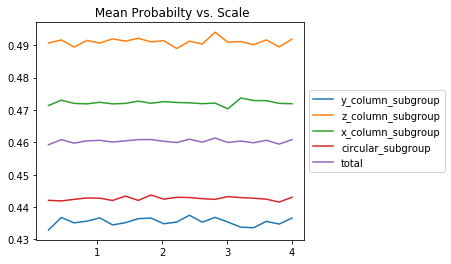

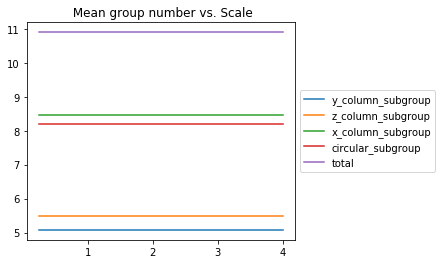

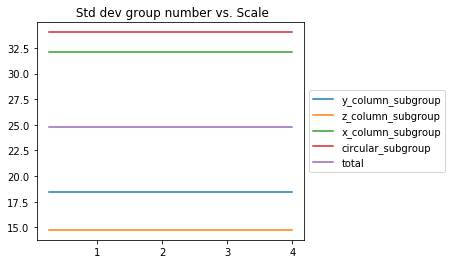

In [61]:
"""
Graphs want to do 
1) The mean probability of each group vs. center
2) The mean group number of each group vs. center
3) The std dev group number of each group vs. center
4) Number neurons that were tested in each radian group vs. center

"""

x = list(mse_scale_subgroup.keys())
column_type = list(mse_scale_subgroup[list(x)[0]].keys())

#get the data for each column type
probability_data = dict()
std_dev_group_data = dict()
mean_group_data = dict()
for t in column_type:
    probability_data[t] = [v[t]["mean_probability"] for k,v in mse_scale_subgroup.items()]
    std_dev_group_data[t] = [v[t]["mean_group_number"] for k,v in mse_scale_subgroup.items()]
    mean_group_data[t] = [v[t]["std_dev_group_number"] for k,v in mse_scale_subgroup.items()]
    

plt.figure()
plt.title(" Mean Probabilty vs. Scale")
for t,y in probability_data.items():
    plt.plot(x,y,label=t)
plt.legend()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

fig = plt.figure()

plt.title(" Mean group number vs. Scale")
for t,y in mean_group_data.items():
    plt.plot(x,y,label=t)
plt.legend()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

plt.figure()
plt.title(" Std dev group number vs. Scale")
for t,y in std_dev_group_data.items():
    plt.plot(x,y,label=t)
plt.legend()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

# Heat map of the highest probabilites: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in greater


Total time for neurons = 20.44680953025818


Text(0.5, 1.0, 'Total probability distributions\nx_width = 3281.8985754358864, x_height = 3281.8985754358864\ny_width = 4385.621445508057, y_height = 4385.621445508057\nz_width = 5469.83095905981, z_height = 5469.83095905981\ncircular_radius = 13700\nmean subgroup number = 12.04\nstd dev subgroup number = 7.168\n Mean probability = 0.463')

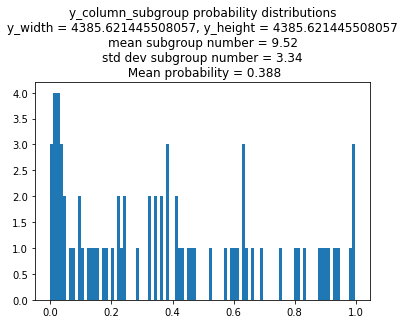

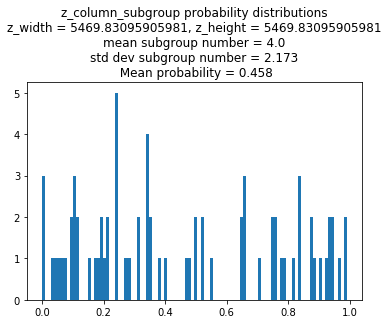

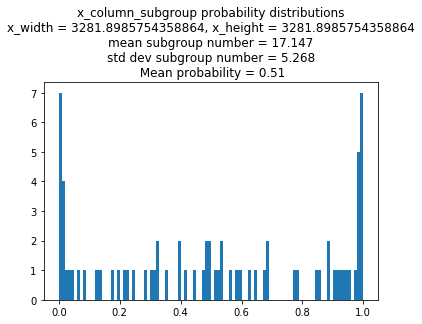

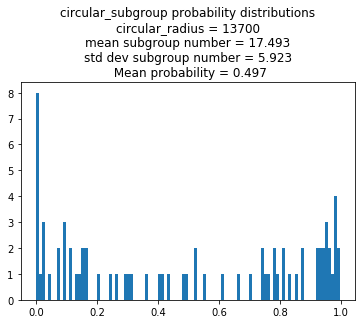

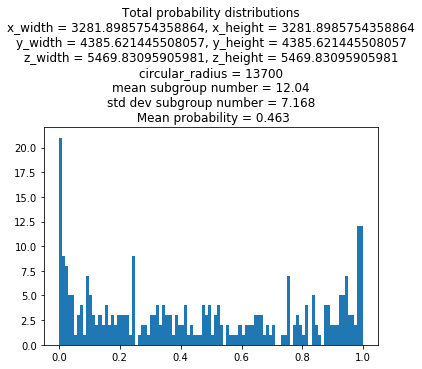

In [62]:
"""Steps for analysis: For each neuron
    1) Get the subgroup (from columns or spheres), can adjust for the same number of neurons or same distance
    2) Calculate the average mse of the orientations of the subgroup from the neuron of interest (aka get the variance)
    3) Calculate the same thing as step 2 but with a random shuffle of neurons from outside the volume (repeat for lots of shuffles so get the distribution)
    4) Compare Step 2 and compute the probability of getting that from the distribution gotten in step 3
    Repeat 1- 4 for all neurons

Look at what the average probability is for all neurons and see if there is instane wher
    
    
mse from the columns

keep the column heights and sphere volume the same"""
import time
def calc_mse(restricted_neuron_group,
             target_scaled
            ):
    
    restricted_neuron_group_orientation_preference = np.array([seg_id_to_orientation[k] for k in restricted_neuron_group])

    #now to get the total list shifted by subtracting off the target neuron
    total_neurons_scaled = restricted_neuron_group_orientation_preference*2

    differences = pycs.pairwise_cdiff(total_neurons_scaled,target_scaled)/2
    squared_difference = np.mean(differences**2)
    
    return squared_difference

mse_data = dict()

start_time = time.time()
for target_neuron in soma_cell_location_dict.keys():
    

    mse_data[target_neuron] = dict()

    target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


    target_scaled = target_neuron_orientation_preferene*2
    """
    Example of how to find neurons within a certain radius
    """
    total_neurons_list = list(soma_cell_location_dict.keys())
    total_neurons_list.remove(target_neuron)

    """
    Example of how to find neurons within x column
    """

    # test 1
    y_width = y_height = 11000
    z_width = z_height = 11000
    x_width = x_height = 11000
    circular_radius = 13000
    
    # test 2 (more strict to try and keep around 10 neurons for at least 90 %)
    y_width = y_height = 6600
    z_width = z_height = 11900
    x_width = x_height = 2850
    circular_radius = 13700
    
    #test 3 (with equal volume) 
    y_new_width = 4385.621445508057
    z_new_width = 5469.83095905981
    x_new_width = 3281.8985754358864
    
    y_width = y_height = y_new_width
    z_width = z_height = z_new_width
    x_width = x_height = x_new_width
    
    
    width_axis = "x_distance"; height_axis = "z_distance"
    y_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,y_width,y_height)

    
    width_axis = "x_distance"; height_axis = "y_distance"
    z_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,z_width,z_height)

    
    width_axis = "y_distance"; height_axis = "z_distance"
    x_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,x_width,x_height)

    
    circular_subgroup = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius)


    subgroups_list = dict(y_column_subgroup=y_column_subgroup,
                         z_column_subgroup=z_column_subgroup,
                         x_column_subgroup=x_column_subgroup,
                         circular_subgroup=circular_subgroup)

    n_random_shuffles = 1000


    
    for subgroup_name,restricted_neuron_group in subgroups_list.items():
        #get the mse of that subgroup
        restricted_neuron_group_mse = calc_mse(restricted_neuron_group,
                                              target_scaled)
        outside_neurons = [k for k in total_neurons_list if 
                       ((k not in restricted_neuron_group) and 
                        k != target_neuron)]
#         print("len(restricted_neuron_group) = " + str(len(restricted_neuron_group)))
#         print("len(outside_neurons) = " + str(len(outside_neurons)))
        
        random_shuffles_mse = []
        for i in range(0,n_random_shuffles):
            #get a random list from outside the subgroup
            if len(restricted_neuron_group) < len(outside_neurons):
                outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
            else:
                if i == 1:
                    print("not using sampling")
                outside_neurons_rand = outside_neurons
            
            if len(restricted_neuron_group) < len(outside_neurons_rand):
                print("RESTRICTED GROUP NUMBER IS LESS")
            random_shuffles_mse.append(calc_mse(outside_neurons_rand,
                                              target_scaled))

        #save the random shuffles
        mse_data[target_neuron][subgroup_name] = dict() 
        mse_data[target_neuron][subgroup_name]["shuffles"] = random_shuffles_mse
        mse_data[target_neuron][subgroup_name]["real_group"] = restricted_neuron_group_mse
        mse_data[target_neuron][subgroup_name]["real_group_len"] = len(restricted_neuron_group)
        
        probability_less_than = np.sum(random_shuffles_mse<restricted_neuron_group_mse)/len(random_shuffles_mse)
        mse_data[target_neuron][subgroup_name]["probability"] = probability_less_than
print(f"Total time for neurons = " + str(time.time() - start_time))


x_parameter_string = f"x_width = {x_width}, x_height = {x_height}"
y_parameter_string = f"y_width = {y_width}, y_height = {y_height}"
z_parameter_string = f"z_width = {z_width}, z_height = {z_height}"
sphere_parameter_string = f"circular_radius = {circular_radius}"


whole_parameters_string = "\n"+x_parameter_string+ \
                            "\n"+y_parameter_string+ \
                            "\n"+z_parameter_string+ \
                            "\n"+sphere_parameter_string

parameter_strings = [y_parameter_string,z_parameter_string,x_parameter_string,
                    sphere_parameter_string]

whole_parameters_string

#get all of the probabilities for each group

column_sphere_names = subgroups_list.keys()
total_probabilities = []
total_group_number = []
column_sphere_subgroup_number = dict()
column_sphere_probabilities = dict()
for volume_name,param in zip(column_sphere_names,parameter_strings):
    column_sphere_probabilities[volume_name] = []
    column_sphere_subgroup_number[volume_name] = []
    for a in mse_data.keys():
            column_sphere_probabilities[volume_name].append(mse_data[a][volume_name]["probability"])
            column_sphere_subgroup_number[volume_name].append(mse_data[a][volume_name]["real_group_len"])
    plt.figure()
    plt.hist(column_sphere_probabilities[volume_name],bins=100)
    mean_group_number = np.mean(column_sphere_subgroup_number[volume_name])
    std_dev_group_number = np.std(column_sphere_subgroup_number[volume_name])
    plt.title(volume_name  + " probability distributions\n" + param 
                           + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                           + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                            + "\n Mean probability = " + str(np.round(np.mean(column_sphere_probabilities[volume_name]),3)))
    total_group_number += column_sphere_subgroup_number[volume_name]
    total_probabilities += column_sphere_probabilities[volume_name]
    
    
mean_group_number = np.mean(total_group_number)
std_dev_group_number = np.std(total_group_number)

plt.figure()
plt.hist(total_probabilities,bins=100)
plt.title("Total probability distributions" + whole_parameters_string
         + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
         + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
         + "\n Mean probability = " + str(np.round(np.mean(total_probabilities),3)))

# ----- 2nd Part: Start graphing the heat maps according to the locations in the volume --

# Radius Clustering

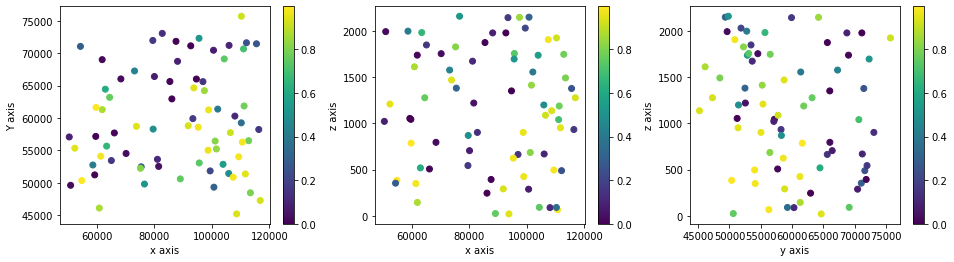

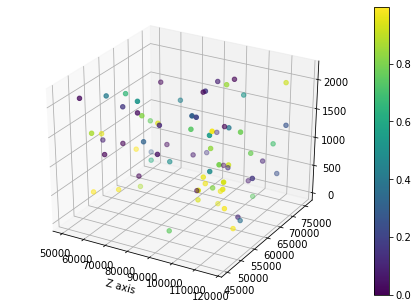

In [63]:
#Shows clustering of the circular subgroups

y_col_values = [mse_data[a]["circular_subgroup"]["probability"] for a in soma_cell_location_dict.keys()]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])

fig = plt.figure(figsize=(16,4))
fig.tight_layout()
ax = plt.subplot(1,3,1)
sc = ax.scatter(soma_centers_list[:,0],
           soma_centers_list[:,1], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('Y axis')
plt.colorbar(sc)

ax = plt.subplot(1,3,2)

sc = ax.scatter(soma_centers_list[:,0],
           soma_centers_list[:,2], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('z axis')
plt.colorbar(sc)

ax = plt.subplot(1,3,3)
sc = ax.scatter(soma_centers_list[:,1],
           soma_centers_list[:,2], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('y axis')
ax.set_ylabel('z axis')
plt.colorbar(sc)


#soma_cell_location_dict

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

sc = ax.scatter(soma_centers_list[:,0], soma_centers_list[:,1], soma_centers_list[:,2],c=y_col_values)
ax.set_xlabel("X axis")
ax.set_xlabel("Y axis")
ax.set_xlabel("Z axis")
plt.colorbar(sc)
pyplot.show()

# Y Column Clustering

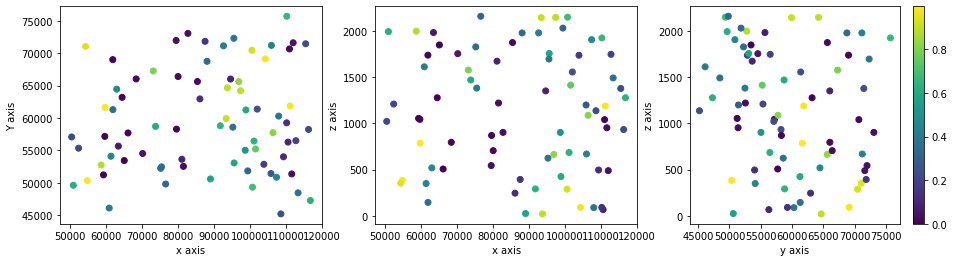

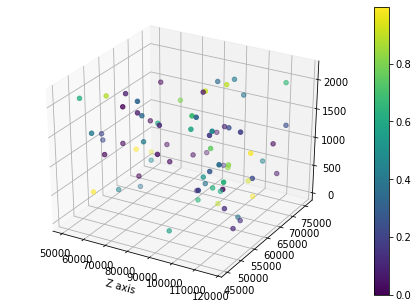

In [64]:
#Total groups = ['y_column_subgroup', 'z_column_subgroup', 'x_column_subgroup', 'circular_subgroup']
y_col_values = [mse_data[a]["y_column_subgroup"]["probability"] for a in soma_cell_location_dict.keys()]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])

fig = plt.figure(figsize=(16,4))
fig.tight_layout()
ax = plt.subplot(1,3,1)
sc = ax.scatter(soma_centers_list[:,0],
           soma_centers_list[:,1], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('Y axis')


ax = plt.subplot(1,3,2)

sc = ax.scatter(soma_centers_list[:,0],
           soma_centers_list[:,2], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('z axis')


ax = plt.subplot(1,3,3)
sc = ax.scatter(soma_centers_list[:,1],
           soma_centers_list[:,2], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('y axis')
ax.set_ylabel('z axis')
plt.colorbar(sc)


#soma_cell_location_dict
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

sc = ax.scatter(soma_centers_list[:,0], soma_centers_list[:,1], soma_centers_list[:,2],c=y_col_values)
ax.set_xlabel("X axis")
ax.set_xlabel("Y axis")
ax.set_xlabel("Z axis")
plt.colorbar(sc)
pyplot.show()

# Z Column Clustering

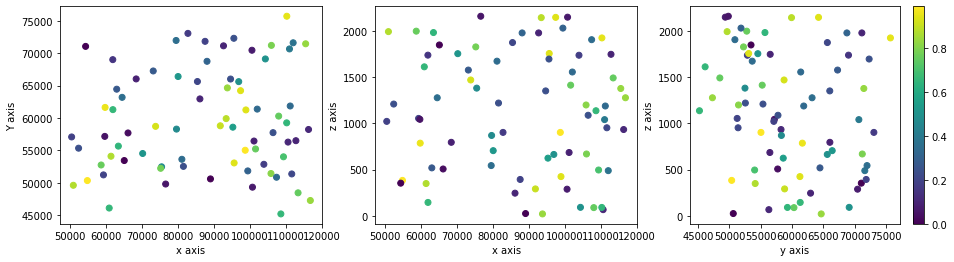

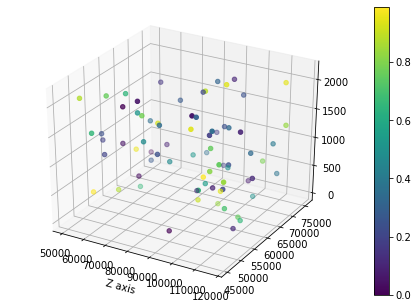

In [65]:
#Total groups = ['y_column_subgroup', 'z_column_subgroup', 'x_column_subgroup', 'circular_subgroup']
y_col_values = [mse_data[a]["z_column_subgroup"]["probability"] for a in soma_cell_location_dict.keys()]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])

fig = plt.figure(figsize=(16,4))
fig.tight_layout()
ax = plt.subplot(1,3,1)
sc = ax.scatter(soma_centers_list[:,0],
           soma_centers_list[:,1], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('Y axis')


ax = plt.subplot(1,3,2)

sc = ax.scatter(soma_centers_list[:,0],
           soma_centers_list[:,2], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('z axis')


ax = plt.subplot(1,3,3)
sc = ax.scatter(soma_centers_list[:,1],
           soma_centers_list[:,2], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('y axis')
ax.set_ylabel('z axis')
plt.colorbar(sc)


from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

sc = ax.scatter(soma_centers_list[:,0], soma_centers_list[:,1], soma_centers_list[:,2],c=y_col_values)
ax.set_xlabel("X axis")
ax.set_xlabel("Y axis")
ax.set_xlabel("Z axis")
plt.colorbar(sc)
pyplot.show()

#soma_cell_location_dict

# X column clustering

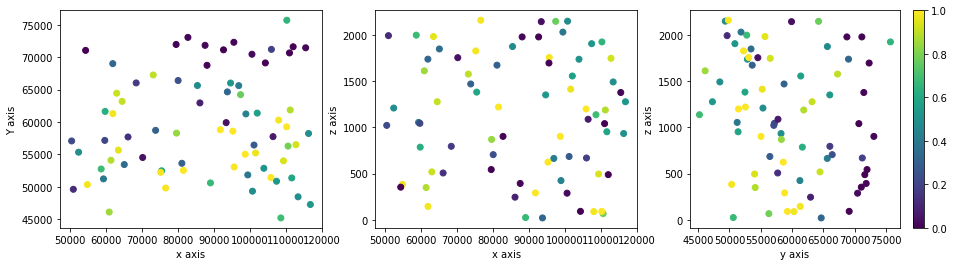

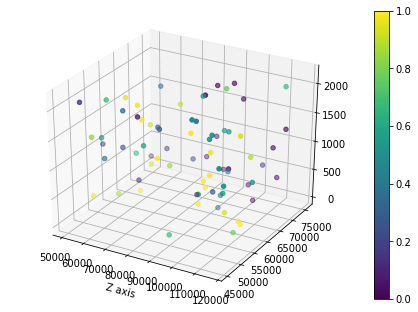

In [66]:
#Total groups = ['y_column_subgroup', 'z_column_subgroup', 'x_column_subgroup', 'circular_subgroup']
y_col_values = [mse_data[a]["x_column_subgroup"]["probability"] for a in soma_cell_location_dict.keys()]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])

fig = plt.figure(figsize=(16,4))
fig.tight_layout()
ax = plt.subplot(1,3,1)
sc = ax.scatter(soma_centers_list[:,0],
           soma_centers_list[:,1], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('Y axis')


ax = plt.subplot(1,3,2)

sc = ax.scatter(soma_centers_list[:,0],
           soma_centers_list[:,2], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('z axis')


ax = plt.subplot(1,3,3)
sc = ax.scatter(soma_centers_list[:,1],
           soma_centers_list[:,2], 
           c=y_col_values, 
           marker='o')

ax.set_xlabel('y axis')
ax.set_ylabel('z axis')
plt.colorbar(sc)

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

sc = ax.scatter(soma_centers_list[:,0], soma_centers_list[:,1], soma_centers_list[:,2],c=y_col_values)
ax.set_xlabel("X axis")
ax.set_xlabel("Y axis")
ax.set_xlabel("Z axis")
plt.colorbar(sc)
pyplot.show()

#soma_cell_location_dict

In [ ]:
circular_subgroup

mse_data[a][volume_name]["probability"]
volume_name

plt.scatter(x=x, y=y, c=value)

# Find what a distribution looks like where subgroup has probability of 1 (put on hold for right now):

In [ ]:
# how to get the distributions from one of the shuffles
target_neuron = 648518346341371119
print(target_neuron)
currnet_subgroup = "circular_subgroup"
mse_current_target_shuffles = mse_data[target_neuron][currnet_subgroup]["shuffles"]

mse_current_target_real  = mse_data[target_neuron][currnet_subgroup]["real_group"]
probability_less_than = np.sum(mse_current_target_shuffles<mse_current_target_real)/len(mse_current_target_shuffles)
plt.figure()
plt.hist(mse_current_target_shuffles,bins= 40)
print("mse_current_target_real = " + str(mse_current_target_real))
print("probability_less_than = " + str(probability_less_than))

In [ ]:
# finding how all of the probabilities change as you scale the volumes

# Shuffling for validation: 

In [ ]:
print("hi")

In [ ]:
import random

outside_neurons = [k for k in total_neurons_list if 
                   ((k not in restricted_neuron_group) and 
                    k != target_neuron)]
#checking that correct
#print(np.sum([len(outside_neurons),len(restricted_neuron_group),1]))

# get a random shuffling of the outside neurons
outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
print(len(outside_neurons_rand))
outside_neurons_rand

In [ ]:
"""
Need to shift the neurons so we can get the 
get the list of global neurons that are not the specific neuron or subset
"""

target_neuron = 648518346341371119
target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]

"""
Example of how to find neurons within a certain radius
"""
total_neurons_list = list(soma_cell_location_dict.keys())
total_neurons_list.remove(target_neuron)

#get total list of orientations without the target neuron
total_neurons_list_orientation_preference = np.array([seg_id_to_orientation[k] for k in total_neurons_list])
len(total_neurons_list_orientation_preference)

#now to get the total list shifted by subtracting off the target neuron
target_scaled = target_neuron_orientation_preferene*2
total_neurons_scaled = total_neurons_list_orientation_preference*2

differences = pycs.pairwise_cdiff(total_neurons_scaled,target_scaled)/2
squared_difference = np.sum(differences**2)

#store this as an outcome in the overall probability distribution

    

In [ ]:
differences[1]**2

In [ ]:
"""    just making sure computation was equivalent   """
# differences_check = np.array([cdiff(k,target_scaled) for k in total_neurons_scaled])/2
# print((len(differences_check),np.min(differences_check),np.max(differences_check)))

# for d,cd in zip(differences,differences_check):
#     if abs(d-cd) > 0.0001:
#         print("not equal")